<a href="https://colab.research.google.com/github/mahault/Multi-agent-sustainability/blob/main/Sust_AIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling Sustainable Resource Management Using Active Inference**
---
*Mahault Albarracin, Maria Raffa, Paul Kinghorn*
--
Based on the suggestions from the *ICAM Lab* and Filippo Torresan, Department of Informatics and Engineering, University of Sussex.


The following code in progress is the first step towards simulating sustainability under AIF.

In order to deal with sustainability in a very straightforward way, we start by thinking of a simple model, i.e. an agent that is able to sustain itself by learning how to use the resources at its disposal wisely. The agent is in a certain place and has to decide whether or not to eat food that is in the same place, at different time steps.

The agent should learn that it does not have to satisfy its greed immediately, even if it is very hungry, because the aim is to maintain a balance between itself and the environment (i.e. a room with food) as long as possible over time. In this case, it learns to align available resources with its needs.

**Case 1** is the baseline to be sure the model works as intended, and considers a static environment. It refers to an agent deciding whether to eat food or not. It should result in an agent that keeps eating, in an environment where food is always present. We assume the agent is aware of its own location and knows that food is in the same location as it is as well, so it has perfect knowledge of the environment.

**Case 2** considers a dynamic environment, where the agent should learn how to not be greedy over time, i.e. food increases when the agent does not eat.

In [ ]:
#!pip uninstall -y pymdp

In [ ]:
# Import necessary libraries
# !pip install inferactively-pymdp # default

# specific branch sparse_likelihoods_111 for B matrix factorization for Case 2
!pip install git+https://github.com/infer-actively/pymdp.git@sparse_likelihoods_111

  Cloning https://github.com/infer-actively/pymdp.git (to revision sparse_likelihoods_111) to /tmp/pip-req-build-lopzkb_3
  Running command git clone --filter=blob:none --quiet https://github.com/infer-actively/pymdp.git /tmp/pip-req-build-lopzkb_3
  Running command git checkout -b sparse_likelihoods_111 --track origin/sparse_likelihoods_111
  Switched to a new branch 'sparse_likelihoods_111'
  Branch 'sparse_likelihoods_111' set up to track remote branch 'sparse_likelihoods_111' from 'origin'.
  Resolved https://github.com/infer-actively/pymdp.git to commit 03846880dabce7edfd49aef04ac5be87695cb9da
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp #

In [ ]:
from pymdp import inference, control, learning
from pymdp import utils, maths
from pymdp.maths import softmax
from pymdp.agent import Agent
from pymdp.utils import random_B_matrix, is_normalized

In [ ]:
#!pip show pymdp

In [ ]:
from matplotlib.cm import Blues
from matplotlib.colors import Normalize

In [ ]:
print(dir(utils))

['EPS_VAL', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_xn_vn_array', 'construct_controllable_B', 'construct_full_a', 'convert_A_stub_to_ndarray', 'convert_B_stubs_to_ndarray', 'convert_observation_array', 'create_A_matrix_stub', 'create_B_matrix_stubs', 'dirichlet_like', 'get_model_dimensions', 'get_model_dimensions_from_labels', 'initialize_empty_A', 'initialize_empty_B', 'insert_multiple', 'is_normalized', 'is_obj_array', 'itertools', 'norm_dist', 'norm_dist_obj_arr', 'np', 'obj_array', 'obj_array_from_list', 'obj_array_ones', 'obj_array_uniform', 'obj_array_zeros', 'onehot', 'pd', 'plot_beliefs', 'plot_likelihood', 'plt', 'process_observation', 'process_observation_seq', 'random_A_matrix', 'random_B_matrix', 'random_single_categorical', 'read_A_matrix', 'read_B_matrices', 'reduce_a_matrix', 'sample', 'sample_obj_array', 'sns', 'to_obj_array', 'warnings']


# **1. Case 1**
-----
Baseline to ensure the model works as intended.

**Static environment**: the food is always present and the agent just decides whether to eat or not.

**Expected result**: the agent always eats whenever it is hungry.


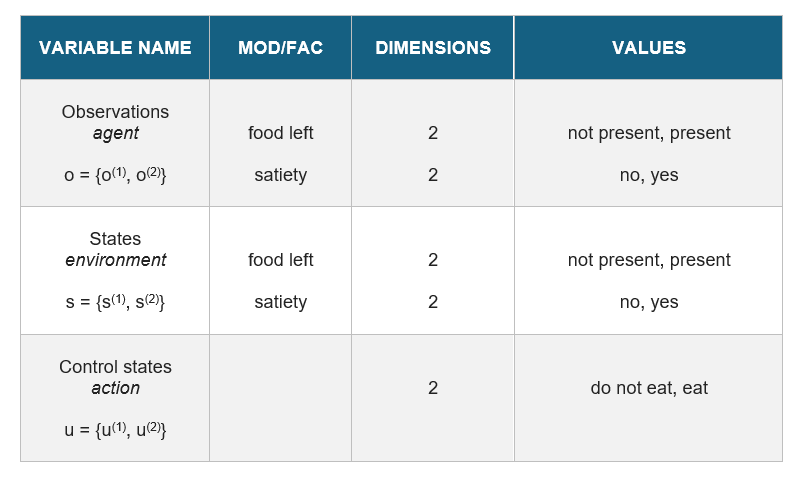

## **1.1. Generative model**

In [ ]:
# observations
obs_food = ['not present', 'present']
obs_satiety = ['no', 'yes']

# states
s_food = ['not present', 'present']
s_satiety = ['no', 'yes']

# controls
choice = ['do not eat', 'eat']

In [ ]:
# observation modality dimensions
num_obs = [len(obs_food), len(obs_satiety)]

# hidden state factors and dimensions
num_states = [len(s_food), len(s_satiety)]
num_factors = [len(num_states)]
num_controls = [2,2] # the same action has influence on both state, so the total num_controls is a list of two 2

# control state factor dimensions
num_control_factors = [len(choice)]

In [ ]:
num_factors

[2]

In [ ]:
num_obs

[2, 2]

In [ ]:
num_states

[2, 2]

In [ ]:
num_controls

[2, 2]

### Observation model (Perception) - *A matrix*
---

P (O|S)

x = State 0 food left

y = obs

z = State 1 satiety


In [ ]:
# one array for each obs
# the matrix has 2 rows (obs), 2 columns (state 0 type), 2 slices (state 1 type)

A = utils.initialize_empty_A(num_obs, num_states)

#### Food left observation





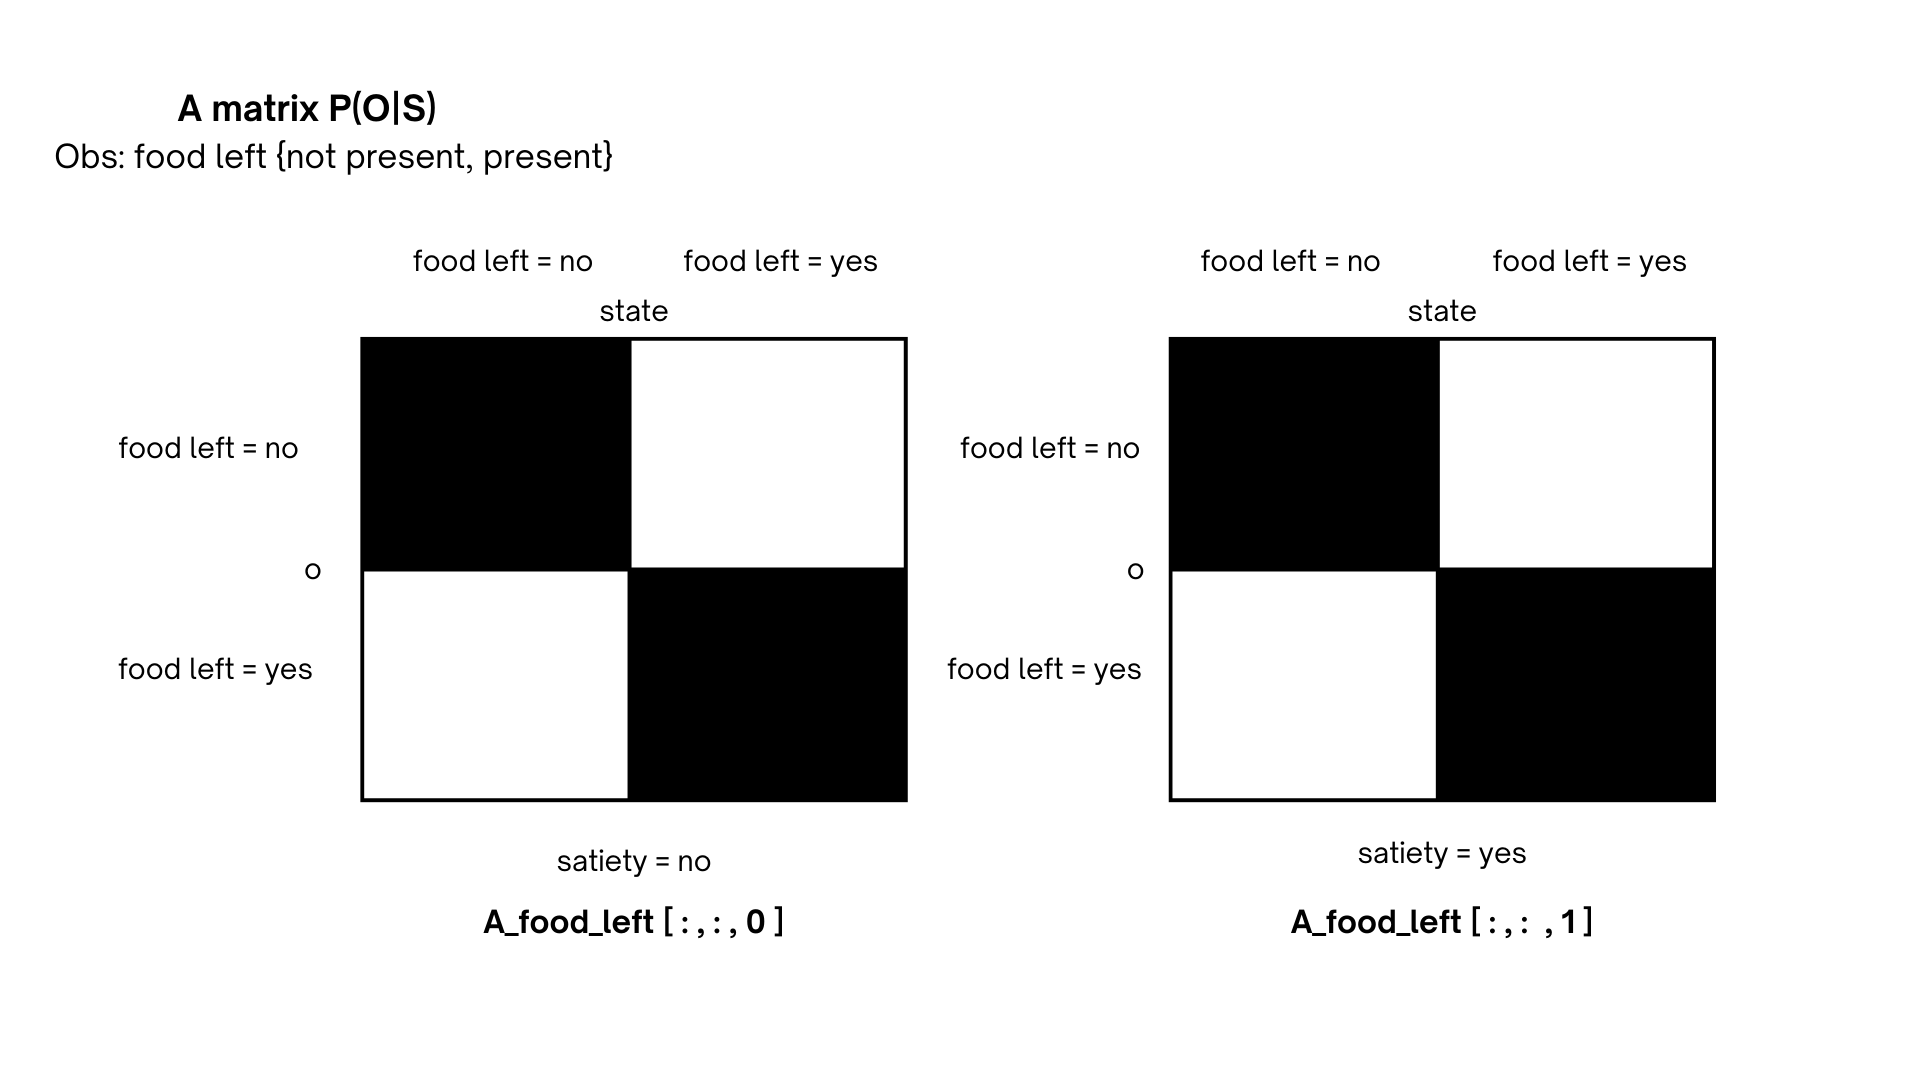

Both identities: food observation is the same with respect to food state.

In [ ]:
A_food_left = np.zeros((len(obs_food), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_food_left[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = no (0), state food = not present (0), state satiety = no (0) should be 100% prob
A_food_left[0,0,0] = 1.0
print(A_food_left)

# Obs food left = yes (1), state food = not present (0), state satiety = no (0) should be 0%
A_food_left[1,0,0] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = no (0) should be 0%
A_food_left[0,1,0] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = no (0) should be 100%
A_food_left[1,1,0] = 1.0

[[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


In [ ]:
print(A_food_left[1,0,0])

0.0


In [ ]:
A_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
# State satiety = yes -> A_food_left[:,:,1]

# Obs food left = no (0), state food = not present (0), state satiety = yes (1)
A_food_left[0,0,1] = 1.0

# Obs food left = yes (1), state food = not present (0), state satiety = yes (1) should be 0%
A_food_left[1,0,1] = 0.0

# Obs food left = no (0), state food = present (1), state satiety = yes (0) should be 0%
A_food_left[0,1,1] = 0.0

# Obs food left = yes (1), state food = present (1), state satiety = yes (1)
A_food_left[1,1,1] = 1.0

In [ ]:
A_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
A[0] = A_food_left

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

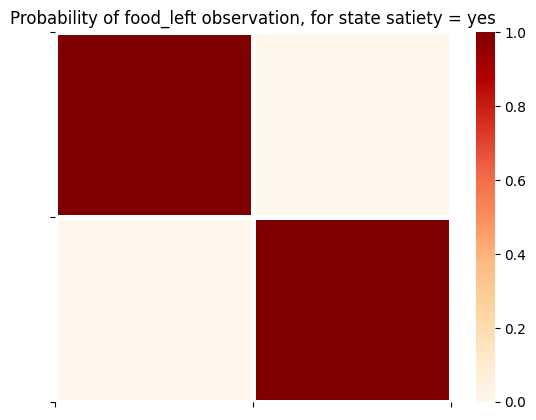

In [ ]:
utils.plot_likelihood(A[0][:,:,1], title = 'Probability of food_left observation, for state satiety = yes')

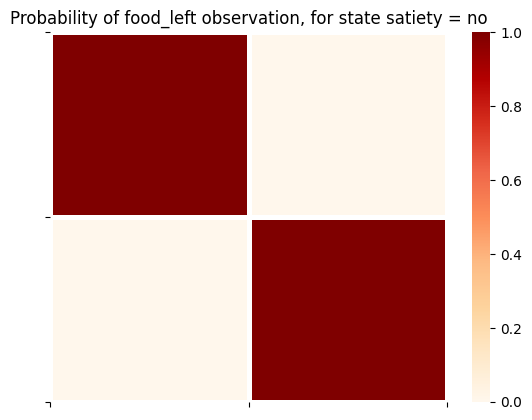

In [ ]:
utils.plot_likelihood(A[0][:,:,0], title = 'Probability of food_left observation, for state satiety = no')

It is an identity, since the food left obs does not depend on satiety.

#### Satiety observation


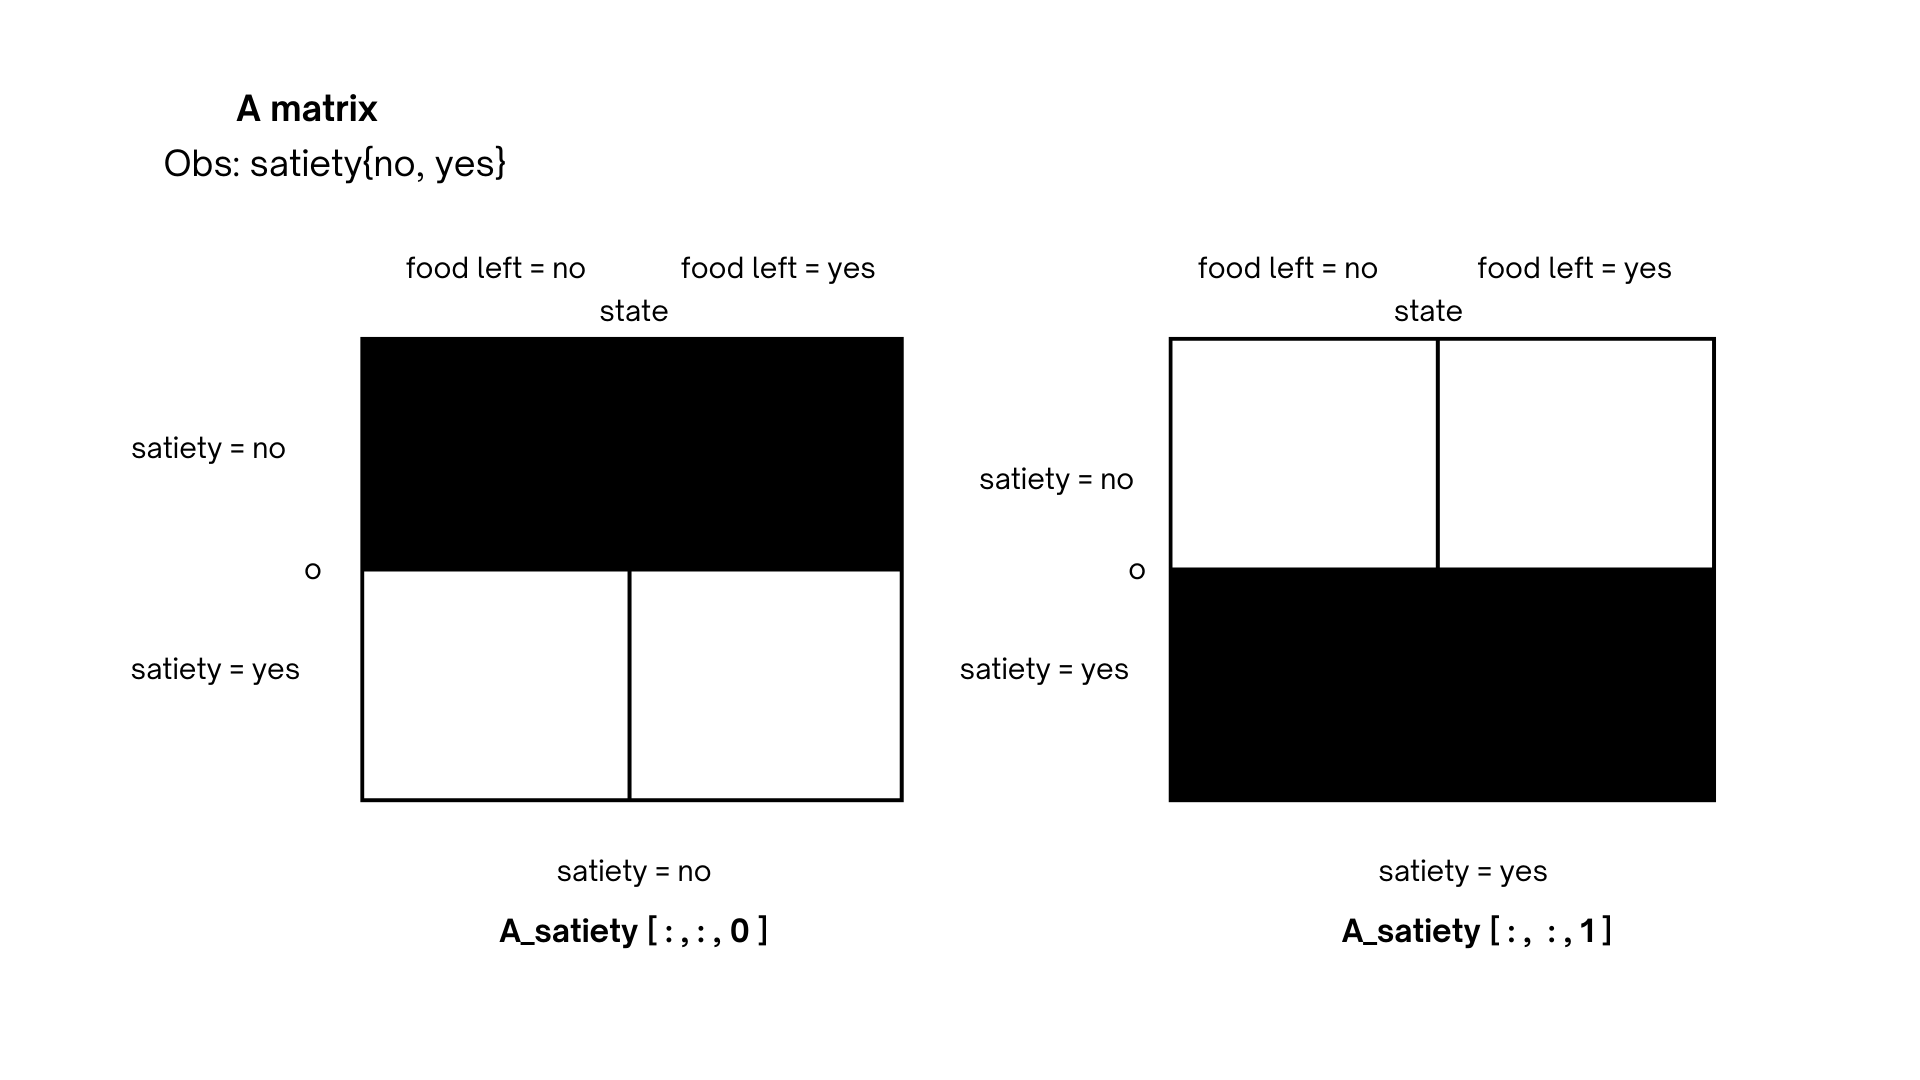

The agent is always hungry/not hungry, not depending on the observation of food.

In [ ]:
A_satiety = np.zeros((len(obs_satiety), len(s_food), len(s_satiety)))

In [ ]:
# State satiety = no -> A_satiety[:,:,0]
# State satiety = yes -> A_satiety[:,:,1]

# Obs satiety = no (0), state food = not present/present, state satiety = no (0)
A_satiety[0,:,0] = 1.0

# Obs satiety = yes (1), state food = not present/present, state satiety = no (0)
A_satiety[1,:,0] = 0.0

# Obs satiety = no (0), state food = not present/present, state satiety = yes (1)
A_satiety[0,:,1] = 0.0

# Obs satiety = yes (1), state food = not present/present, state satiety = yes (1)
A_satiety[1,:,1] = 1.0

In [ ]:
 A_satiety[:,:,0] # satiety = no

array([[1., 1.],
       [0., 0.]])

In [ ]:
A_satiety[:,:,1] # satiety = yes

array([[0., 0.],
       [1., 1.]])

In [ ]:
A_satiety[:,0,:]  # food = not present
                  # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety[:,1,:] # # food = present
                 # this should be identity

array([[1., 0.],
       [0., 1.]])

In [ ]:
A_satiety

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
 A[1] = A_satiety

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

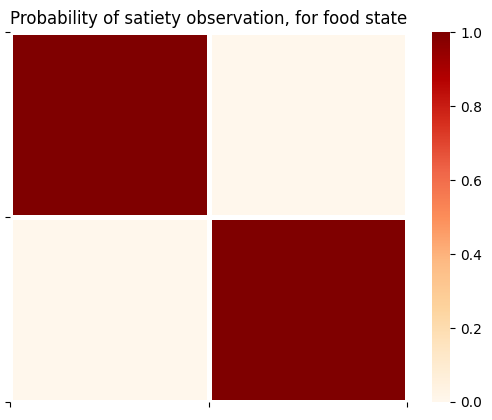

In [ ]:
utils.plot_likelihood(A[1][:,0,:], title = 'Probability of satiety observation, for food state')
                                   # this should be identity

The above are identity, since if food is not present the satiety is the same.

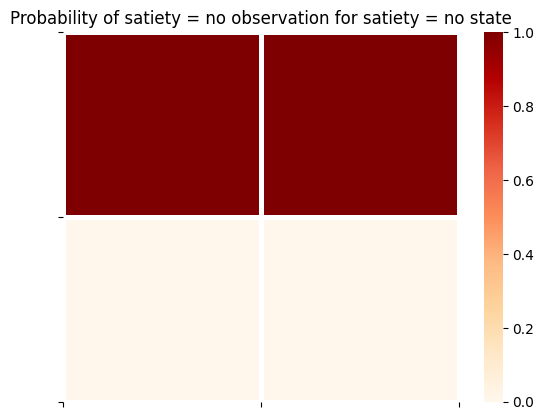

In [ ]:
utils.plot_likelihood(A[1][:,:,0], title = 'Probability of satiety = no observation for satiety = no state')

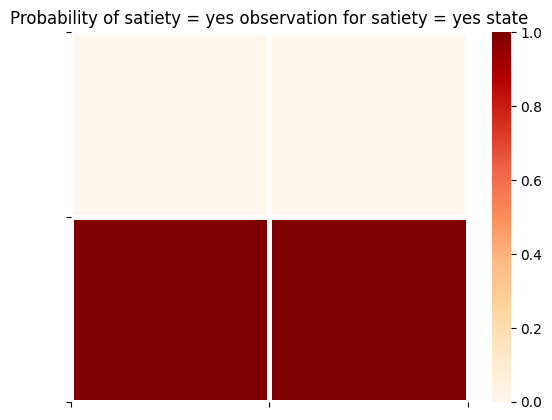

In [ ]:
utils.plot_likelihood(A[1][:,:,1], title = 'Probability of satiety = yes observation for satiety = yes state')

The agent is hungry/full when satiety state is no/yes, regardless food left.

In [ ]:
A

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(A)

numpy.ndarray

In [ ]:
A[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

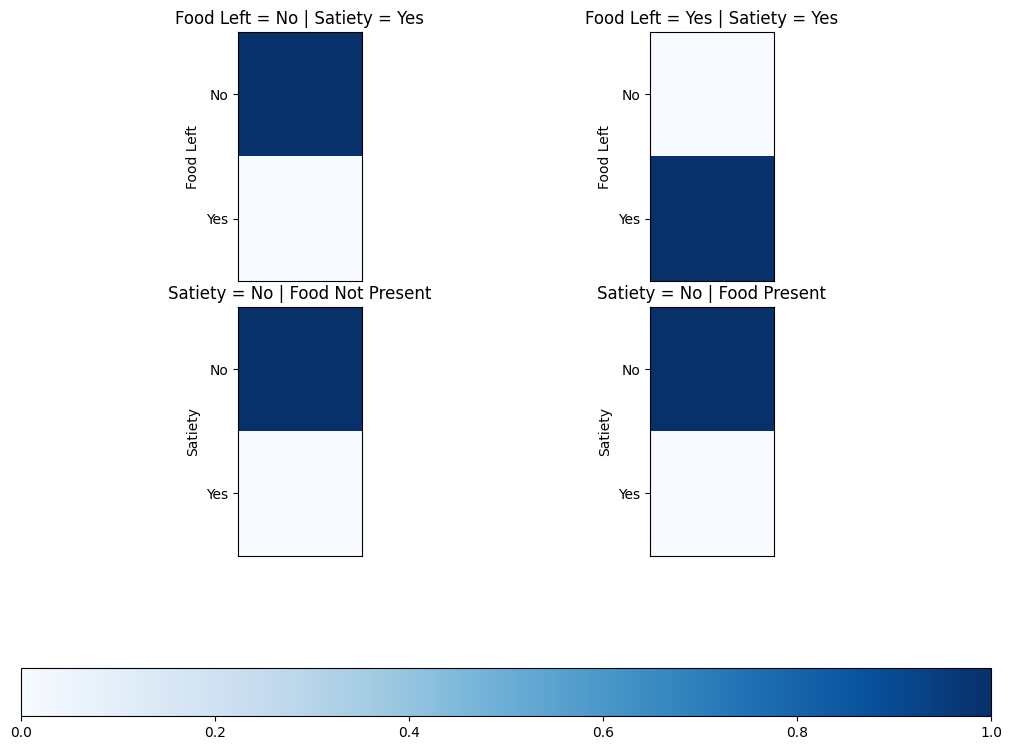

In [ ]:
# Plot both A_food_left and A_satiety together
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Titles for subplots
titles = ['Food Left = No | Satiety = Yes', 'Food Left = Yes | Satiety = Yes',
          'Satiety = No | Food Not Present', 'Satiety = No | Food Present']

# Plot for A_food_left
for i in range(2):
    im = axes[0, i].imshow(A_food_left[:, i, 1].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_ylabel('Food Left')

# Plot for A_satiety
for i in range(2):
    im = axes[1, i].imshow(A_satiety[:, i, 0].reshape(2, 1), cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i+2])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_ylabel('Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()

### Transition model (Planning) - *B matrix*
----

P(St|St-1, Ut-1)

x = State t-1

y = State t

z = Control state

---

We set the matrices so that the the environment does not change, and food is always present. Since there is not learning on the B matrix, this will not affect the AIF loop.

In [ ]:
num_states

[2, 2]

In [ ]:
# we need one slice matrix for each state
# we have the same number for actions and states (2)
# transition depends on the current state only: for each action we have a matrix that describes the prob of moving from each state to every other state

B = utils.initialize_empty_B(num_states, num_states)

In [ ]:
B

array([array([[[0., 0.],
               [0., 0.]],

              [[0., 0.],
               [0., 0.]]]), array([[[0., 0.],
                                    [0., 0.]],

                                   [[0., 0.],
                                    [0., 0.]]])], dtype=object)

#### Food left state

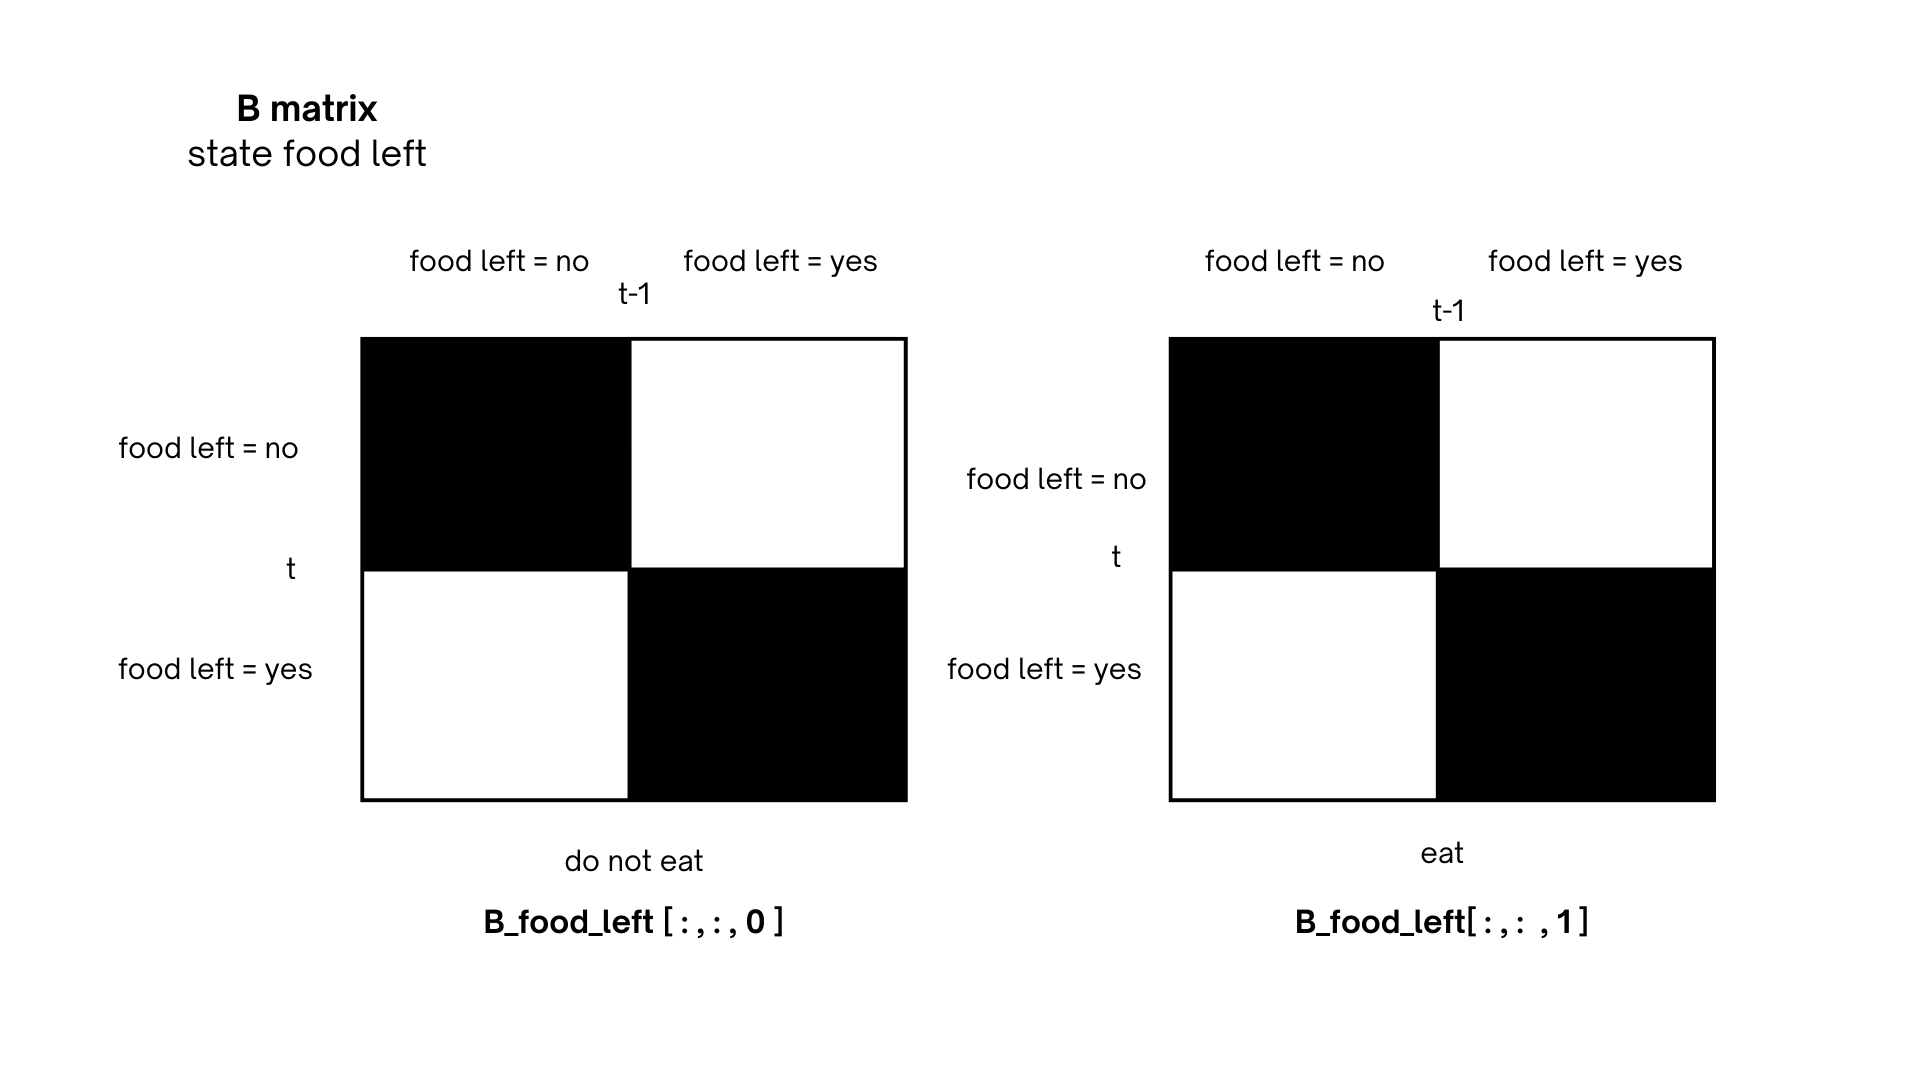

Both identities: food is always present, so there are no changes despite eating or not.

In [ ]:
B_food_left = np.zeros( (len(s_food), len(s_food), len(choice)) )

In [ ]:
# Action = do not eat -> B_food_left[:,:,0]
# Action = eat -> B_food_left[:,:,1]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = no (0), state t-1: food left = no (0), action = eat/not eat 100% prob
B_food_left[0,0,:] = 1.0

# state t: food left = yes (1), state t-1: food = no (0), action: eat/not eat 0%
B_food_left[1,0,:] = 0.0

# state t: food left = no (0), state t-1: food = yes (1), action: eat/not eat 0%
B_food_left[0,1,:] = 0.0

# state t: food left = yes (1), state t-1: food = yes (1), action: eat/not eat should be 100%
B_food_left[1,1,:] = 1.0

In [ ]:
B_food_left[:,:,0]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0] = B_food_left

In [ ]:
def plot_likelihoodB(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="Oranges", cbar=True)
    plt.title(title)
    plt.xlabel("State t-1")
    plt.ylabel("State t")
    plt.show()

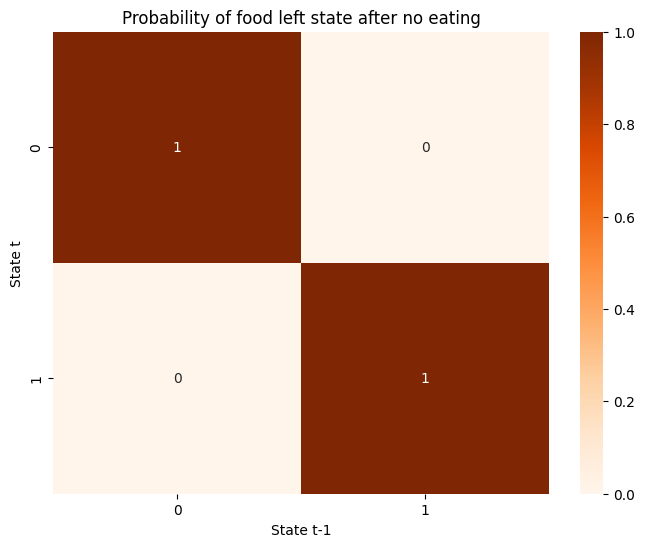

In [ ]:
plot_likelihoodB(B[0][:,:,0], title = 'Probability of food left state after no eating' )

In [ ]:
B_food_left[:,:,1]

array([[1., 0.],
       [0., 1.]])

In [ ]:
B[0]

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

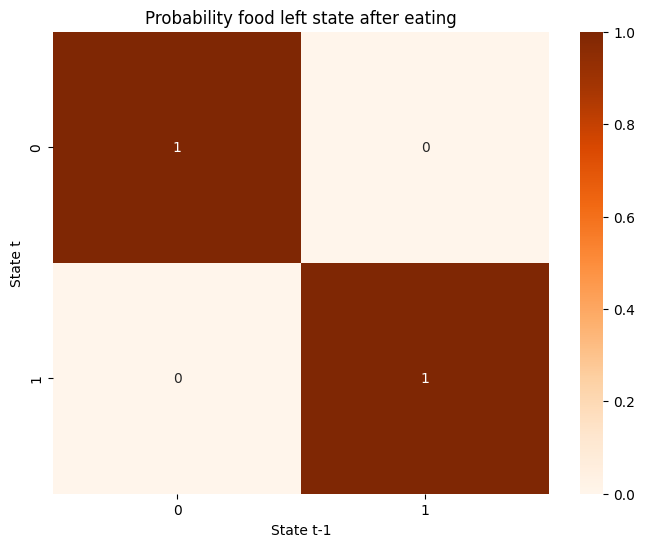

In [ ]:
plot_likelihoodB(B[0][:,:,1], title = 'Probability food left state after eating' )

#### Satiety state

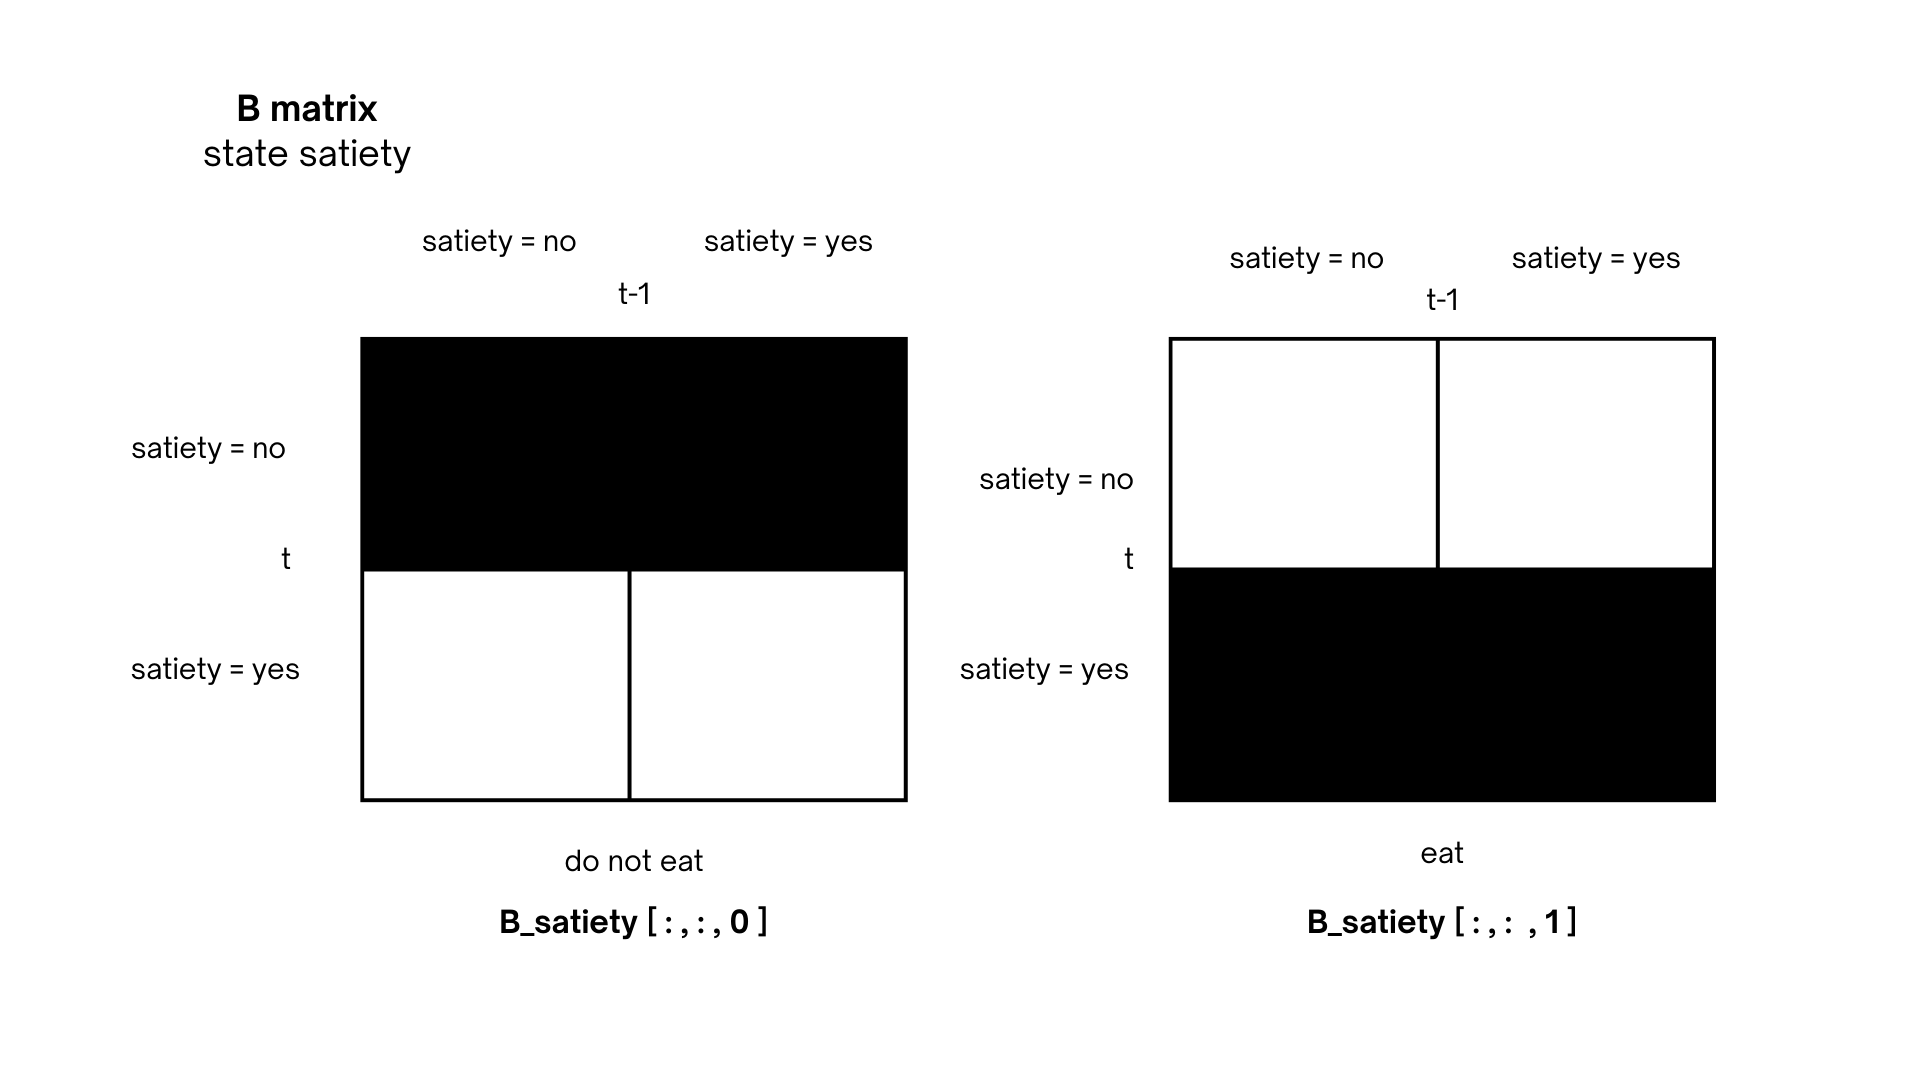

The agent is always hungry (satiety = no) after no eating and always full (satiety = yes) after eating.

In [ ]:
B_satiety = np.zeros( (len(s_satiety), len(s_satiety), len(choice)))

In [ ]:
# Action = do not eat -> B_satiety[:,:,0]
# Action = eat -> B_satiety[:,:,1]

#F index 1: state t, index 2: state t-1, index 3: action

# State t: satiety = no (0), state t-1: satiety = yes/no, action = do not eat (0)
B_satiety[0,:,0] = 1.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[1,:,0] = 0.0 # chances of being full when not  eating regardless of starting state is 0

# State t: satiety = no (0), state t-1: satiety = yes/no, action: do not eat (0) should be 0%
B_satiety[0,:,1] = 0.0

# State t: satiety = yes (1), state t-1: satiety = yes/no, action: do not eat (0) should be 100%
B_satiety[1,:,1] = 1.0 # chances of being full when eating regardless of starting state is 1

In [ ]:
B[1] = B_satiety

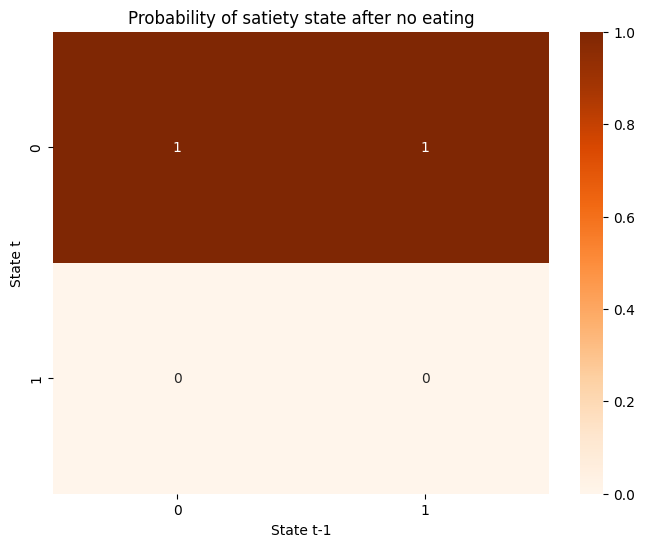

In [ ]:
# chances of being full when not  eating regardless of starting state is
plot_likelihoodB(B[1][:,:,0], title = 'Probability of satiety state after no eating')

In [ ]:
B_satiety[:,:,1]

array([[0., 0.],
       [1., 1.]])

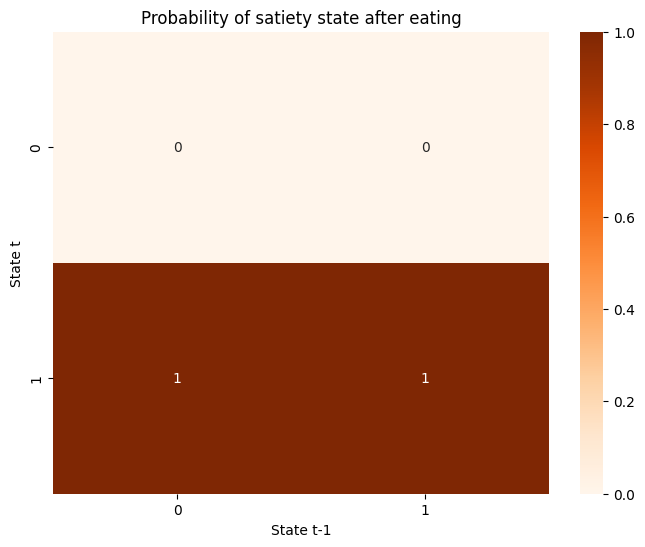

In [ ]:
# chances of being full when eating regardless of starting state is 1

plot_likelihoodB(B[1][:,:,1], title = 'Probability of satiety state after eating' )

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
type(B)

numpy.ndarray

In [ ]:
# check if the matrix is normalised
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = B.sum(axis=0)
sums = B[1].sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalised.")
else:
    print("The matrix is not normalised. Sums:", sums)

print("Is the B matrix normalised?", utils.is_normalized(B))

The matrix is properly normalised.
Is the B matrix normalised? True


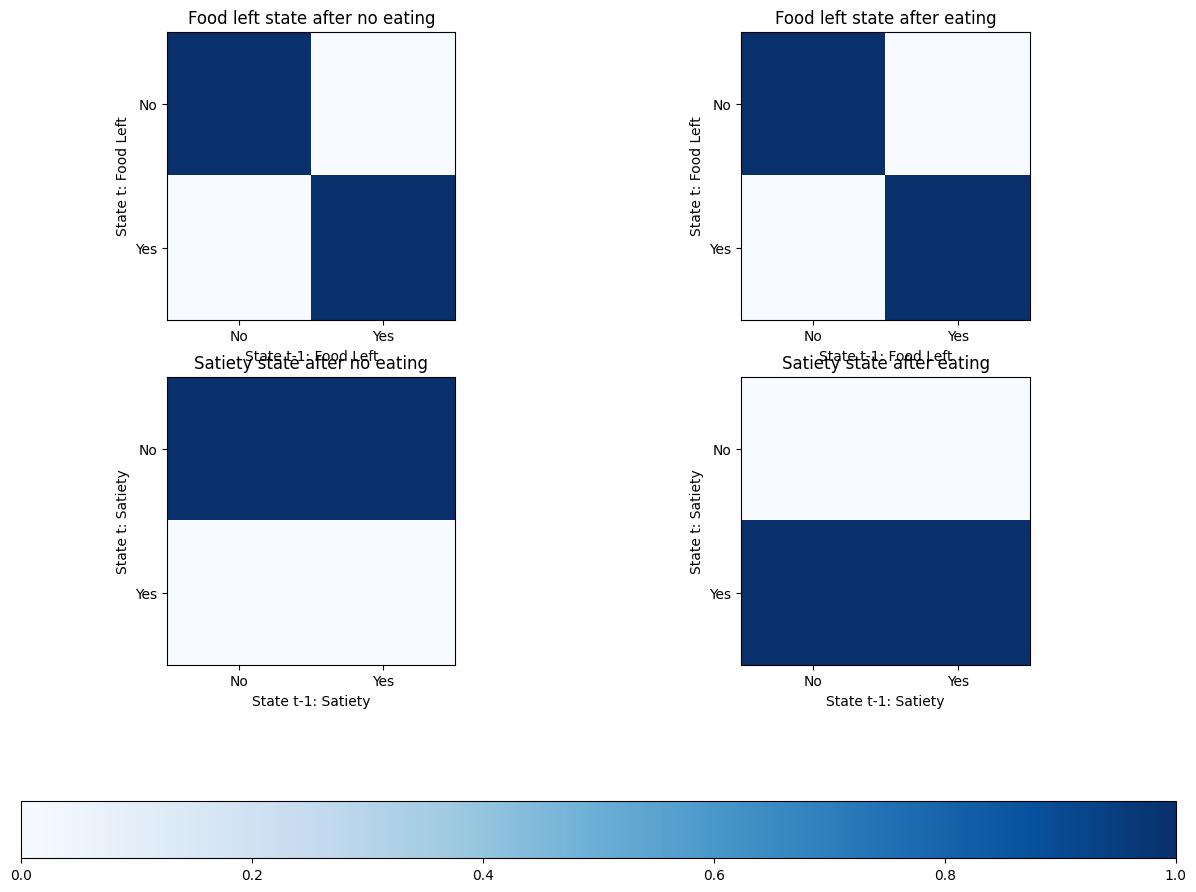

In [ ]:
# plot both B_food_left and B_satiety together

# Titles for each subplot
titles = [
    "Food left state after no eating",
    "Food left state after eating",
    "Satiety state after no eating",
    "Satiety state after eating"
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
action_labels = ['Do Not Eat', 'Eat']

for i in range(2):
    im = axes[0, i].imshow(B_food_left[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xticks([0, 1])
    axes[0, i].set_yticks([0, 1])
    axes[0, i].set_xticklabels(['No', 'Yes'])
    axes[0, i].set_yticklabels(['No', 'Yes'])
    axes[0, i].set_xlabel('State t-1: Food Left')
    axes[0, i].set_ylabel('State t: Food Left')

    im = axes[1, i].imshow(B_satiety[:, :, i], cmap='Blues', vmin=0, vmax=1)
    axes[1, i].set_title(titles[i + 2])
    axes[1, i].set_xticks([0, 1])
    axes[1, i].set_yticks([0, 1])
    axes[1, i].set_xticklabels(['No', 'Yes'])
    axes[1, i].set_yticklabels(['No', 'Yes'])
    axes[1, i].set_xlabel('State t-1: Satiety')
    axes[1, i].set_ylabel('State t: Satiety')

fig.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
plt.show()


In [ ]:
print(B[1].shape)

(2, 2, 2)


### Prior preferences - *C vector*


We set an agent that has a strong preference for being full (*satiety* = yes) and *food_left* = present.

In [ ]:
# create prior preferences over observations (C vector)
# our agent has a strong preference for obs satiety = yes

C = utils.obj_array_zeros([num_obs])

In [ ]:
# Define preferences for each observation modality
# index 1: mod not present/no, index 2: mod present/yes C[0][:,1] C[1][:,1]

C_food_left = np.array([0.0, 20.0])  # preference for the observation modality of food present
C_satiety = np.array([0.0, 20.0])  # preference for the observation modality of satiety

# create an object array to hold each modality's preferences
C = np.empty(2, dtype=object)
C[0] = C_food_left
C[1] = C_satiety

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

In [ ]:
len(C)

2

In [ ]:
type(C)

numpy.ndarray

In [ ]:
print("C vector:", C)
for i, pref in enumerate(C):
    print(f"Preferences for modality {i}: {pref}") #modality 0: food_left; 1: satiety

C vector: [array([ 0., 20.]) array([ 0., 20.])]
Preferences for modality 0: [ 0. 20.]
Preferences for modality 1: [ 0. 20.]


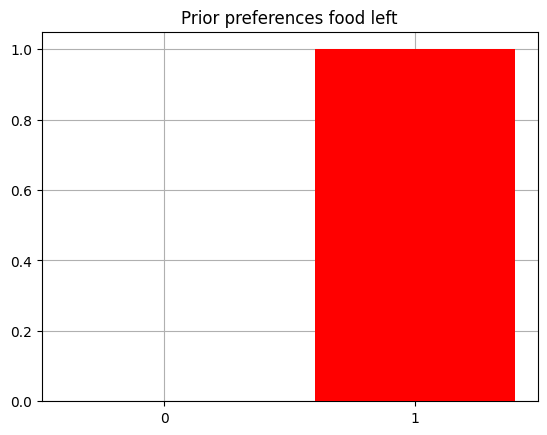

In [ ]:
utils.plot_beliefs(softmax(C[0]), title = "Prior preferences food left")

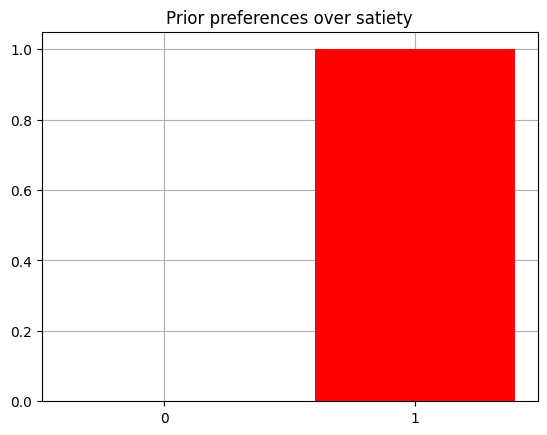

In [ ]:
utils.plot_beliefs(softmax(C[1]), title = "Prior preferences over satiety")

Following *D vector* for initial beliefs is superfluous/could mess thing up

In [ ]:
# specify prior over hidden states (D vector)

# D = utils.obj_array(num_factors)

# we set at t = 0 strong beliefs over hidden state food left = yes D[0][:,1] and satiety = no D[1][0,:]

# D_food_left = np.array([0.0, 20.0])
# D_satiety = np.array([20.0, 0.0])

# create an object array to hold each modality's preferences
#D = np.empty(2, dtype=object)
#D[0] = D_food_left
#D[1] = D_satiety

#utils.plot_beliefs(softmax(D[0]), title = "Initial beliefs about probability of food left state")

## **1.2 Generative Process**

### Agent

We set the agents beliefs matching the actual structure of the environment: food present and satiety no

In [ ]:
my_agent = Agent(A=A, B=B, C=C, policies=None, action_selection="stochastic") # we do not pass D vector, it is flat

In [ ]:
my_agent.B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
my_agent.policy_len #for case 2 agent should be 3

1

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_agent.policies=[np.array([[0,0]]),np.array([[1,1]])] # we need to change the policies, from 4 to 2, so that the agent takes one action only on the two obs modalities
my_agent.E = my_agent._construct_E_prior() # we adjust the E matrix size after having changed policies

In [ ]:
my_agent.policies

[array([[0, 0]]), array([[1, 1]])]

In [ ]:
A[1]

array([[[1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.]]])

In [ ]:
B

array([array([[[1., 1.],
               [0., 0.]],

              [[0., 0.],
               [1., 1.]]]), array([[[1., 0.],
                                    [1., 0.]],

                                   [[0., 1.],
                                    [0., 1.]]])], dtype=object)

In [ ]:
C

array([array([ 0., 20.]), array([ 0., 20.])], dtype=object)

### AIF loop

In [ ]:
from pymdp.envs import Env

In [ ]:
# class for the room environment (generative process)
class room_Env(Env):

    def __init__(self):

        # initial states
        self.state_food = 1 # food present
        self.state_satiety = 0 # no satiety

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        print(action)
        if action == 0:  # do not eat
            # state does not change
            self.state_food = 1
            self.state_satiety = 0

        elif action == 1 and self.state_food == 1: # eat
            # food is always 'present', satiety 'yes'
            self.state_food = 1
            self.state_satiety=1

        elif action == 1 and self.state_food == 0:
            self.state_food = 0
            self.state_satiety = 0


        # mapping states to observations
        obs_food = self.state_food  # directly use the state as observation
        obs_satiety = self.state_satiety

        obs = [obs_food, obs_satiety]

        return obs

# function to restart the loop
    def reset(self):
        # reset the environment to the initial state
        self.state_food = 1 #food left present
        self.state_satiety = 0 #no satiety

        states = [self.state_food, self.state_satiety]

        return states

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_agent.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_agent.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_agent.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



In [ ]:
print(observation) # index 1: food left; index 2: satiety

[1, 1]


### Results plot

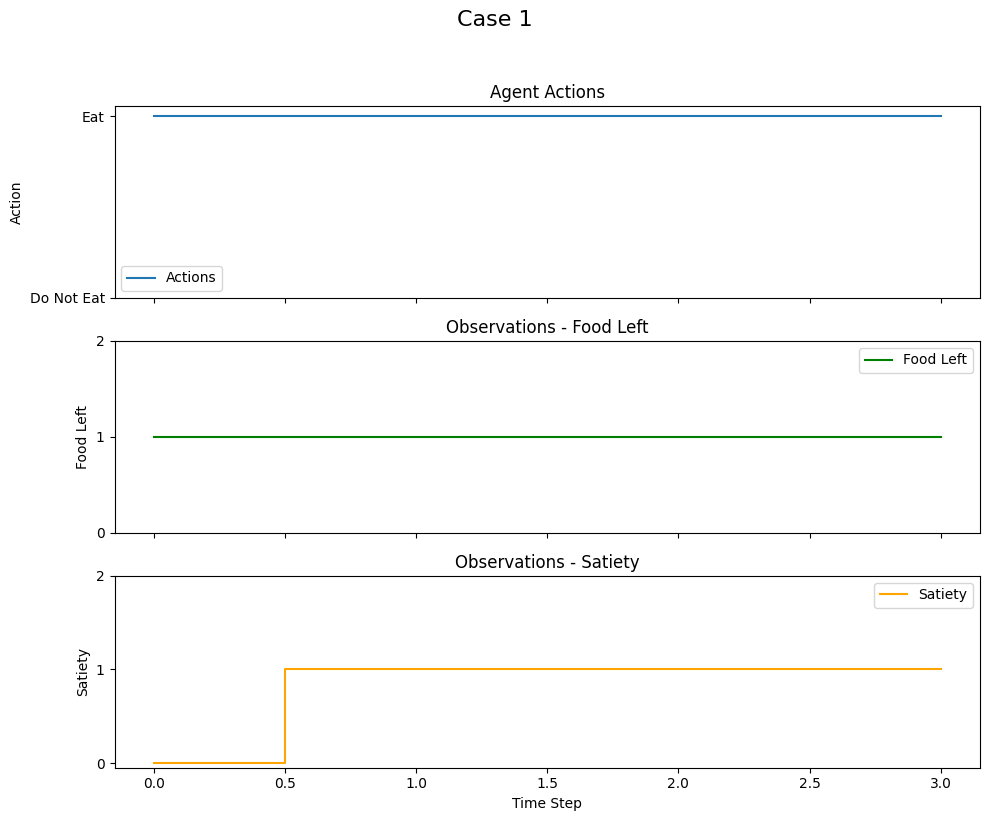

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)


plt.show()

As expected, the agent keeps eating, the food is always available and satiety = yes.

## **1.3 Extending results**

### *1.3.1 Wrong matrices*
Now we set wrong matrices to check whether the agents keeps eating despite them. We make them incorrect by swapping probabilities.

 **Observation model (Perception) - A matrix**

*Food left observation*





In [ ]:
A1 = utils.initialize_empty_A(num_obs, num_states)

In [ ]:
A1[0] = np.copy(A_food_left)

In [ ]:
A_food_left_wrong = A1[0]

In [ ]:
# we introduce some noise in the matrix

A_food_left_wrong[0, 0, 0] = 0.0
A_food_left_wrong[1, 0, 0] = 1.0  # Wrong observation probability
A_food_left_wrong[0, 1, 0] = 1.0
A_food_left_wrong[1, 1, 0] = 0.0  # Wrong observation probability

In [ ]:
print(A_food_left_wrong[1,0,0])

1.0


In [ ]:
A_food_left_wrong[:,:,0]

array([[0., 1.],
       [1., 0.]])

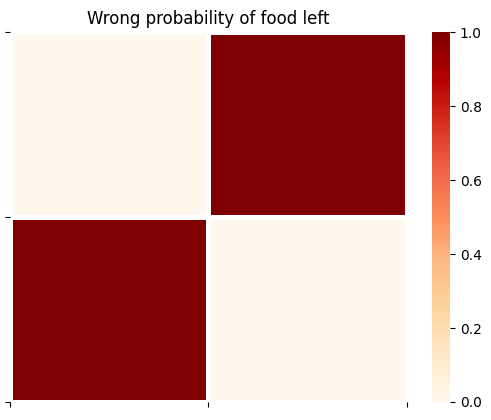

In [ ]:
utils.plot_likelihood(A1[0][:,:,0], title = 'Wrong probability of food left')

*Satiety observation*


In [ ]:
A1[1] = np.copy(A_satiety)

In [ ]:
A_satiety_wrong = A1[1]

In [ ]:
A_satiety_wrong[0, :, 0] = 0.0
A_satiety_wrong[1, :, 0] = 1.0  # Wrong observation probability

In [ ]:
A_satiety_wrong[:,:,0]

array([[0., 0.],
       [1., 1.]])

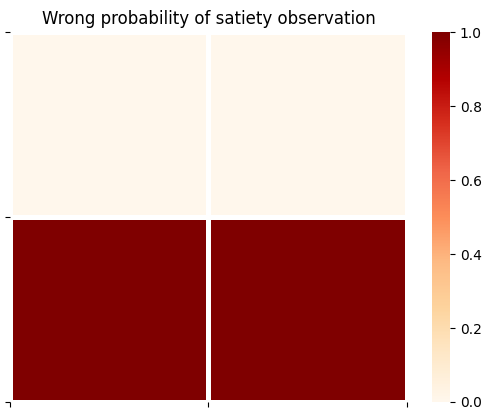

In [ ]:
utils.plot_likelihood(A1[1][:,:,0], title = 'Wrong probability of satiety observation')


**Transition model (Planning) - B matrix**

In [ ]:
B1 = utils.initialize_empty_B(num_obs, num_states)

*Food left state*

In [ ]:
B1[0] = np.copy(B_food_left)

In [ ]:
B_food_left_wrong = B1[0]

In [ ]:
# Introduce noise into the transition matrix
B_food_left_wrong[0, 0, 0] = 0.5
B_food_left_wrong[1, 0, 0] = 0.5  # Wrong transition probability
B_food_left_wrong[0, 1, 0] = 0.5
B_food_left_wrong[1, 1, 0] = 0.5  # Wrong transition probability

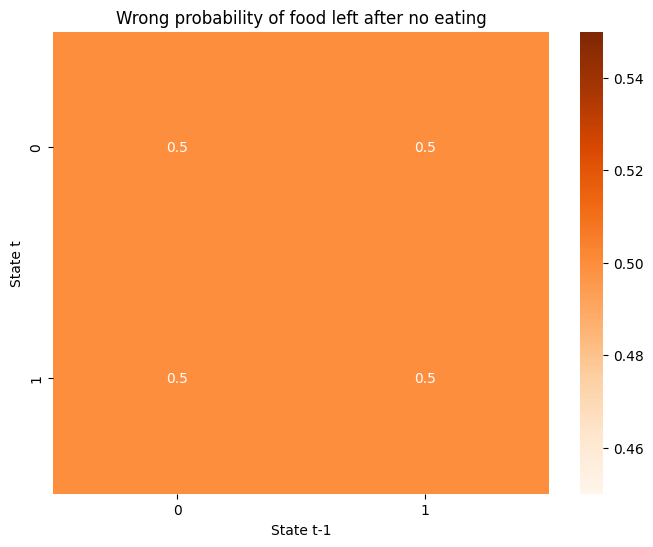

In [ ]:
plot_likelihoodB(B1[0][:,:,0], title = 'Wrong probability of food left after no eating')

*Satiety state*

In [ ]:
B1[1] = np.copy(B_satiety)

In [ ]:
B_satiety_wrong = B1[1]

In [ ]:
B_satiety_wrong[0, 0, 0] = 0.5
B_satiety_wrong[1, 0, 0] = 0.5  # Wrong transition probability

In [ ]:
B_satiety_wrong[:,:,0]

array([[0.5, 1. ],
       [0.5, 0. ]])

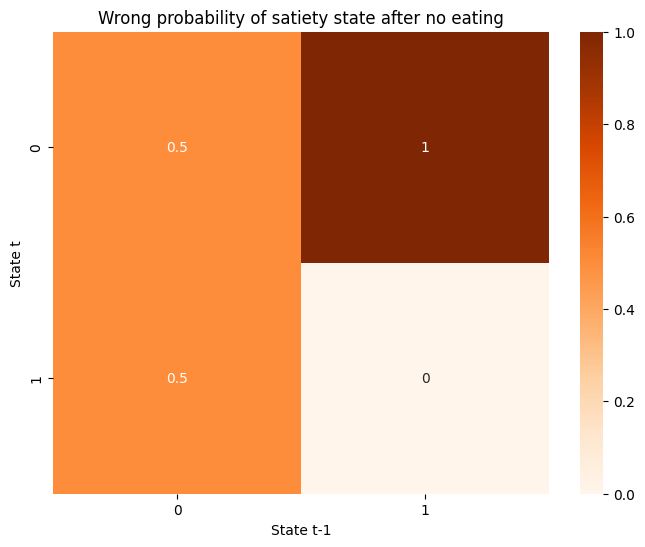

In [ ]:
plot_likelihoodB(B1[1][:,:,0], title = 'Wrong probability of satiety state after no eating')


We set a new agent

In [ ]:
my_w_agent = Agent(A=A1, B=B1, C=C, policies=None, action_selection="stochastic") # we do not pass D vector, it is flatten

In [ ]:
my_w_agent.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_w_agent.policies=[np.array([[0,0]]),np.array([[1,1]])]
my_w_agent.E = my_w_agent._construct_E_prior()

In [ ]:
my_w_agent.policies

[array([[0, 0]]), array([[1, 1]])]

**AIF loop**

The environment is the same as main case1, so now we change the agent in the AIF loop only.

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_w_agent.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_w_agent.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_w_agent.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_w_agent.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



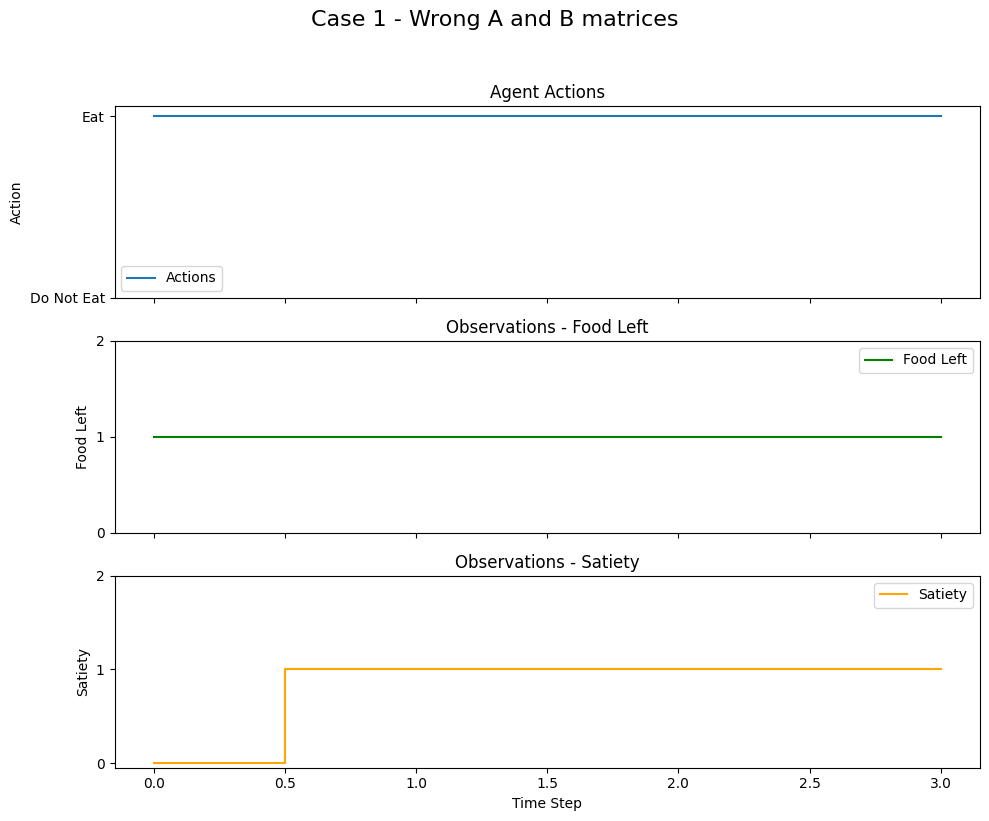

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1 - Wrong A and B matrices", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


Despite the wrong matrices, the agent still prefers to continue eating. (This actually changes with respect to different runs)

### *1.3.2 Different prior preferences*
Now we set an agent that has a strong preference for being full only (*satiety* = yes) and does not care if food is present or not.

In [ ]:
# create prior preferences over observations (C vector)
# our agent has a strong preference for obs satiety = yes

C1 = utils.obj_array_zeros([num_obs])

In [ ]:
# Define preferences for each observation modality
# index 1: mod not present/no, index 2: mod present/yes C[0][:,1] C[1][:,1]

C1_food_left = np.array([0.0, 0.0])  # before we had 0.20 for obs mod food present, now we set flat preference
C1_satiety = np.array([0.0, 20.0])  # preference for the observation modality of satiety

# create an object array to hold each modality's preferences
C1 = np.empty(2, dtype=object)
C1[0] = C1_food_left
C1[1] = C1_satiety

In [ ]:
C1

array([array([0., 0.]), array([ 0., 20.])], dtype=object)

In [ ]:
len(C1)

2

In [ ]:
type(C1)

numpy.ndarray

In [ ]:
print("New C vector:", C1)
for i, pref in enumerate(C1):
    print(f"Preferences for modality {i}: {pref}") #modality 0: food_left; 1: satiety

New C vector: [array([0., 0.]) array([ 0., 20.])]
Preferences for modality 0: [0. 0.]
Preferences for modality 1: [ 0. 20.]


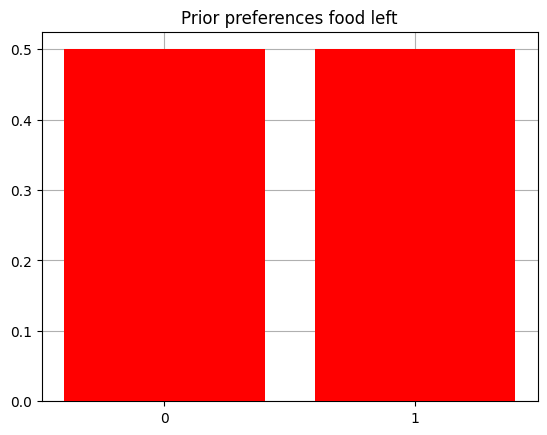

In [ ]:
utils.plot_beliefs(softmax(C1[0]), title = "Prior preferences food left")

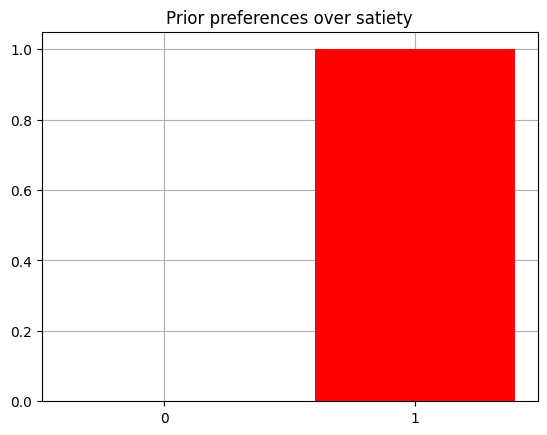

In [ ]:
utils.plot_beliefs(softmax(C1[1]), title = "Prior preferences over satiety")


We set a new agent

In [ ]:
my_agent1 = Agent(A=A, B=B, C=C1, policies=None, action_selection="stochastic") # we do not pass D vector, it is flat

In [ ]:
C1

array([array([0., 0.]), array([ 0., 20.])], dtype=object)

In [ ]:
my_agent1.policies

[array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]])]

In [ ]:
my_agent1.policies=[np.array([[0,0]]),np.array([[1,1]])]
my_agent1.E = my_agent1._construct_E_prior()

In [ ]:
my_agent1.policies

[array([[0, 0]]), array([[1, 1]])]

**AIF loop**

The environment is the same as main case1, so now we change the agent in the AIF loop only.

In [ ]:
# initialize lists to store data
actions = []
observations = []
qs_values = []

env = room_Env()

T = 4  # number of timesteps

# initialize or reset the environment
current_state = env.reset()

# initialize the agent or ensure all necessary internal states are set
my_agent1.reset()

for t in range(T):


    # current observation from the environment

    observation = env.step(action) if t > 0 else current_state  # initial state for the first observation

    # update the agent's belief about the current state based on the observation
    qs = my_agent1.infer_states(observation)  # update state beliefs

    # infer policies based on the updated beliefs
    my_agent1.infer_policies() # it is expected to get 4 values but changed agent policies to get just 2 values

    # debugging print to ensure the agent is ready to sample an action
    print("Agent's internal state (posterior over policies - q_pi):", getattr(my_agent, 'q_pi', 'Attribute not set'))

    # sample the next action from the inferred policies
    action = my_agent1.sample_action()

# print action to check its structure
    print("Sampled action output:", action)
    #print("Type of action:", type(action))
    #print("Shape of action:", np.shape(action))

    # handle action based on its type and structure
    if isinstance(action, np.ndarray) and action.size == 1:
        action = int(action.item())  # convert single-item array to integer
    elif isinstance(action, np.ndarray) and action.ndim > 0:
        print("Action array elements:", action)
        action = int(action[0])  # select the first action if multiple are given
    else:
        print("Unexpected action format. Terminating loop.")
        break

        # Store data for this timestep
    actions.append(action)
    observations.append(observation)
    qs_values.append(qs)

    # results for this timestep
    print(f"Time step {t}, Action taken: {action}, Observation: {observation}")
    print()

Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 0, Action taken: 1, Observation: [1, 0]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 1, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 2, Action taken: 1, Observation: [1, 1]

1
Agent's internal state (posterior over policies - q_pi): [1.06112398e-139 1.00000000e+000]
Sampled action output: [1. 1.]
Action array elements: [1. 1.]
Time step 3, Action taken: 1, Observation: [1, 1]



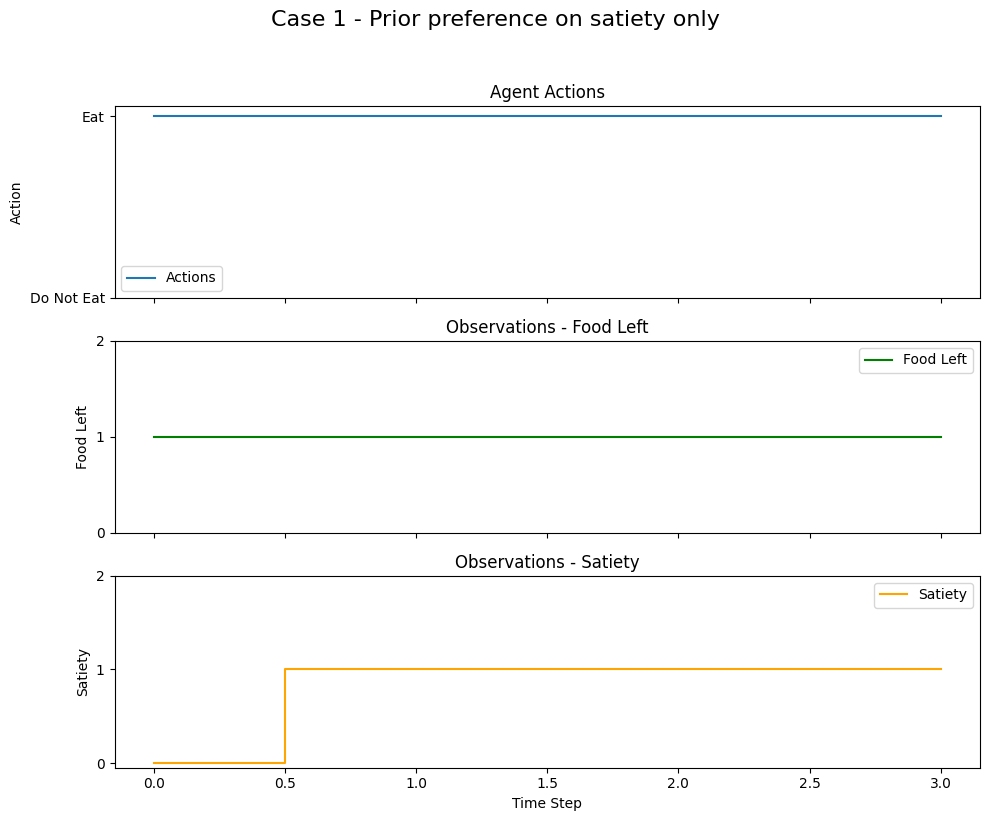

In [ ]:
# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting actions
axs[0].step(time_steps, actions, where='mid', label='Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Extracting and plotting observations
obs_food = [obs[0] for obs in observations]
obs_satiety = [obs[1] for obs in observations]

axs[1].step(time_steps, obs_food, where='mid', label='Food Left', color='green')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

axs[2].step(time_steps, obs_satiety, where='mid', label='Satiety', color='orange')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 1 - Prior preference on satiety only", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


As before, nevertheless the agent has different prior preferences (we have set them just on satiety this time) it keeps eating.

# **2. Case 2**
-----
**Dynamic environment**: food is depleted if the agent eats, grows if it does not eat.The agent should learn how to not be greedy over time.
This might be done by giving more values to hidden states *food_left* and *satiety*.

Over successive timesteps, the agent updates its beliefs about the hidden states using its observations and the A matrix (perception). It then selects actions based on how it expects they will impact future states and observations, as captured in the B matrix (planning). By simulating this perception-action loop under the active inference framework, we can study the emergence of sustainable resource management strategies.

**Expected results**: the agent learns adjusting its eating
behavior according to the food replenishment rate. On the one way, consuming whenever food is present, may lead to periods of starvation. Not eating, on the other way, makes food increasing.
An optimal strategy would involve more conservative eating to sustain a steady level of satiety over time.


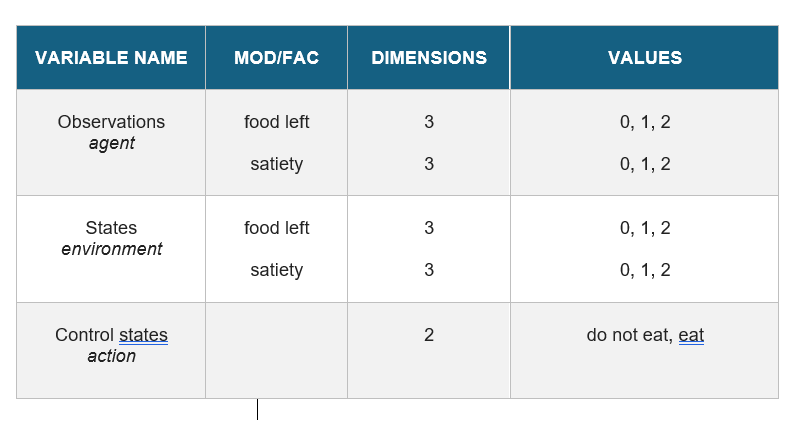

## **2.1 Generative model**

In [ ]:
# observations
obs_food2 = [0 , 1 , 2]
obs_satiety2 = [0 , 1 , 2]

# states
s_food2 = [0 , 1 , 2]
s_satiety2 = [0 , 1, 2]

In [ ]:
# observation modality dimensions
num_obs2 = [len(obs_food2), len(obs_satiety2)]

# hidden state factors and dimensions
num_states2 = [len(s_food2), len(s_satiety2)]
num_factors2 = [len(num_states2)]

In [ ]:
num_obs2

[3, 3]

In [ ]:
num_states2

[3, 3]

In [ ]:
# control state factor dimensions are the same as before
num_controls

[2, 2]

### Observation model (Perception) - *A matrix*

In [ ]:
A2 = utils.initialize_empty_A(num_obs2, num_states2)

#### Food left observation

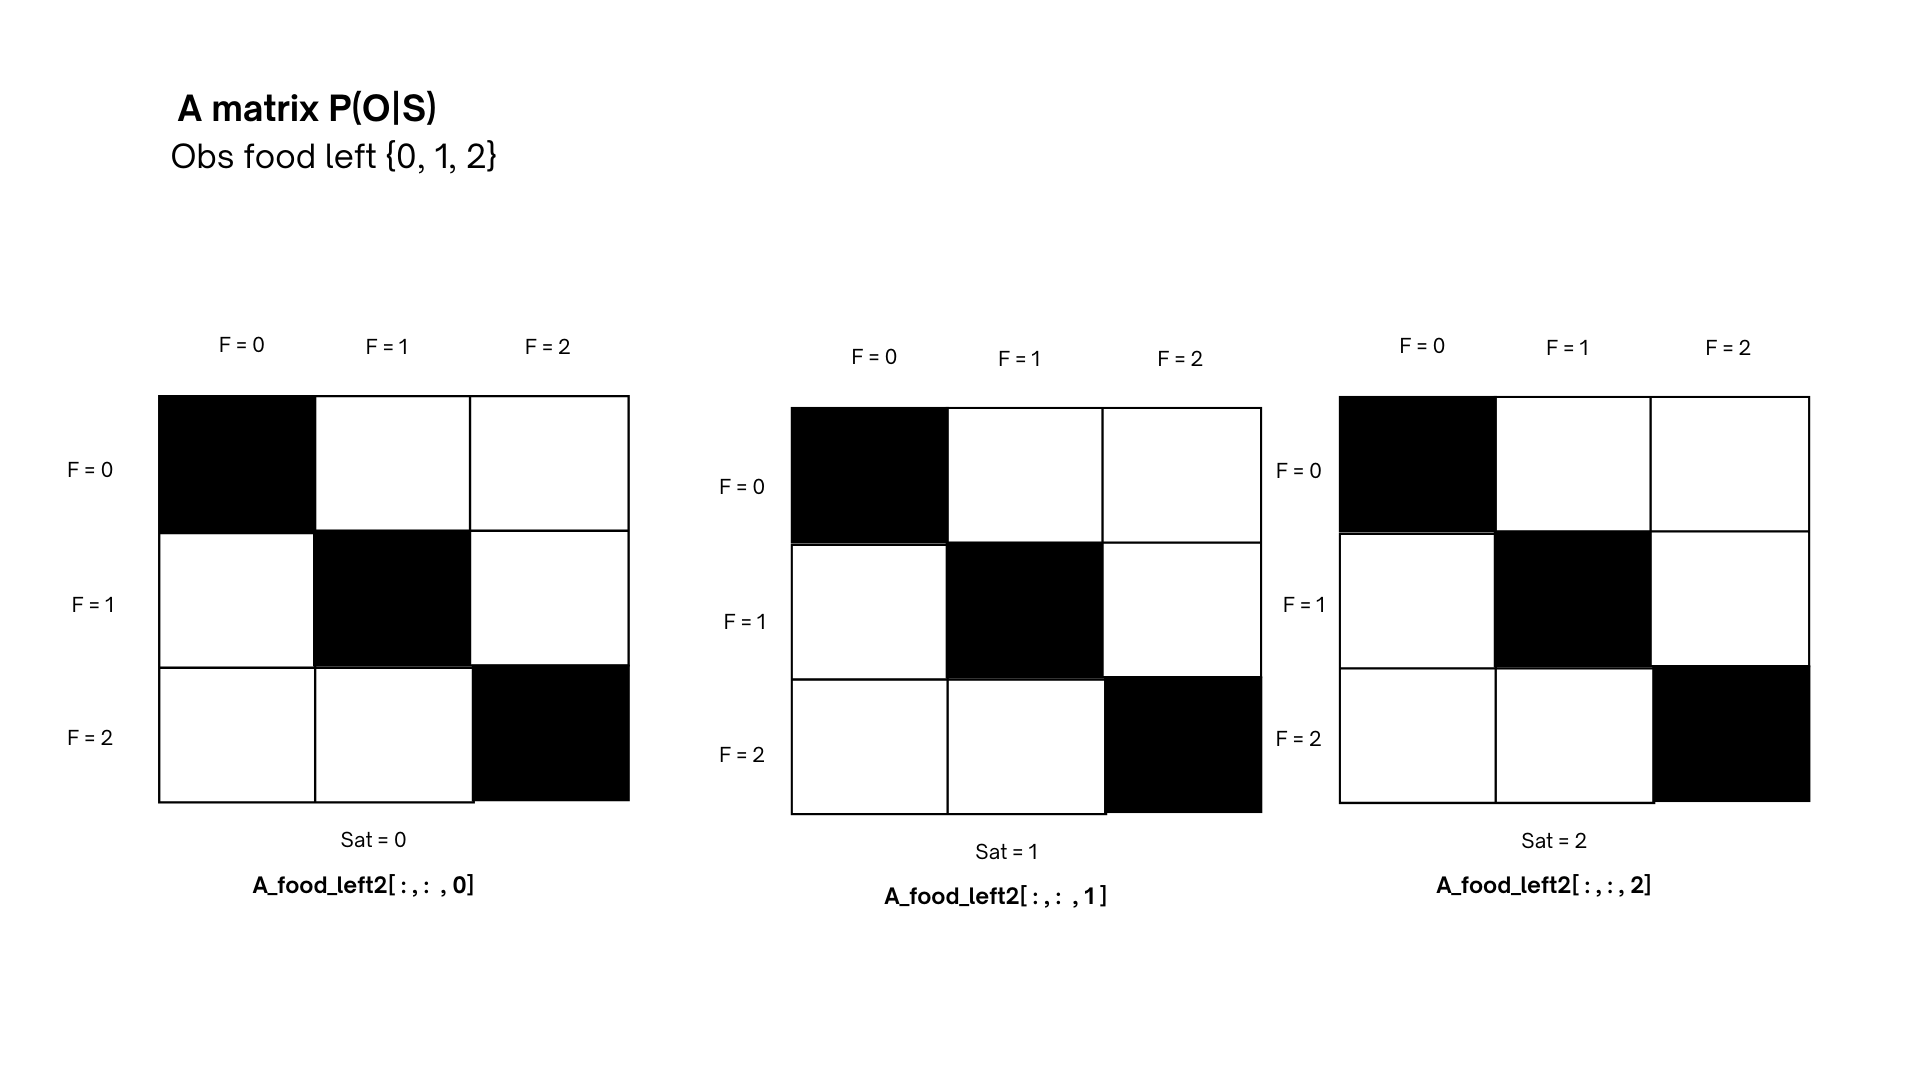

In [ ]:
A_food_left2 = np.zeros((len(obs_food2), len(s_food2), len(s_satiety2)))

In [ ]:
A_food_left2.shape

(3, 3, 3)

In [ ]:
# State satiety = 0 -> A_food_left2[:,:,0]

# index 1: obs food, index 2: state food, index 3: state satiety

# Obs food left = 0, state food = 0, state satiety = 0 should be 100% prob
A_food_left2[0,0,0] = 1.0

# Obs food left = 1, state food = 0, state satiety = 0 should be 0%
A_food_left2[1,0,0] = 0.0

# Obs food left = 2, state food = 0, satiety = 0
A_food_left2[2,0,0] = 0.0

# Obs food left = 0, state food = 1, state satiety = 0 should be 0%
A_food_left2[0,1,0] = 0.0

# Obs food left = 1, state food = 1, state satiety = 0 should be 100%
A_food_left2[1,1,0] = 1.0

#Obs food left = 2, state food = 1, satiety = 0
A_food_left2[2,1,0] = 0

#Obs food left = 2, state food = 2, satiety = 0
A_food_left2[2,2,0] = 1.0


In [ ]:
A_food_left2[:,:,0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# State satiety = 1 -> A_food_left2[:,:,1]

# Obs food left = 0, state food = 0, state satiety = 1 should be 100% prob
A_food_left2[0,0,1] = 1.0

# Obs food left = 1, state food = 0, state satiety = 1 should be 0%
A_food_left2[1,0,1] = 0.0

# Obs food left = 2, state food = 0, satiety = 1
A_food_left2[2,0,1] = 0.0

# Obs food left = 0, state food = 1, state satiety = 1 should be 0%
A_food_left2[0,1,1] = 0.0

# Obs food left = 1, state food = 1, state satiety = 1 should be 100%
A_food_left2[1,1,1] = 1.0

# Obs food left = 2, state food = 1, satiety = 1
A_food_left2[2,1,1] = 0

#Obs food left = 2, state food = 2, satiety = 1
A_food_left2[2,2,1] = 1.0

In [ ]:
A_food_left2[:,:,2]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
# State satiety = 2 -> A_food_left2[:,:,2]


# Obs food left = 0, state food = 0, state satiety = 2 should be 100% prob
A_food_left2[0,0,2] = 1.0

# Obs food left = 1, state food = 0, state satiety = 2 should be 0%
A_food_left2[1,0,2] = 0.0

# Obs food left = 2, state food = 0, satiety = 2
A_food_left2[2,0,2] = 0.0

# Obs food left = 0, state food = 1, state satiety = 2 should be 0%
A_food_left2[0,1,2] = 0.0

# Obs food left = 1, state food = 1, state satiety = 2 should be 100%
A_food_left2[1,1,2] = 1.0

#Obs food left = 2, state food = 1, satiety = 2
A_food_left2[2,1,2] = 0

# Obs food left = 2, state food = 2, satiety = 2
A_food_left2[2,2,2] = 1.0

In [ ]:
A_food_left2[:,:,2]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
A2[0] = A_food_left2

In [ ]:
A2[0]

array([[[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]]])

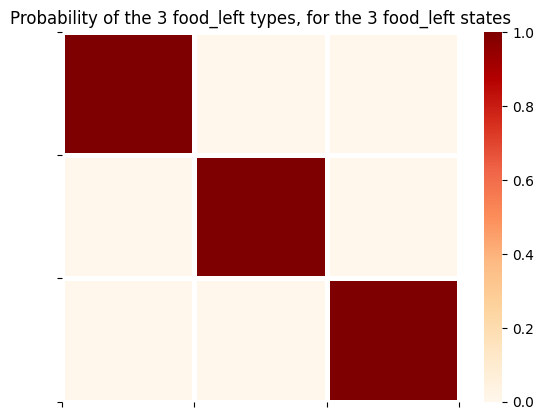

In [ ]:
utils.plot_likelihood(A2[0][:,:,2], title = 'Probability of the 3 food_left types, for the 3 food_left states')

#### Satiety observation


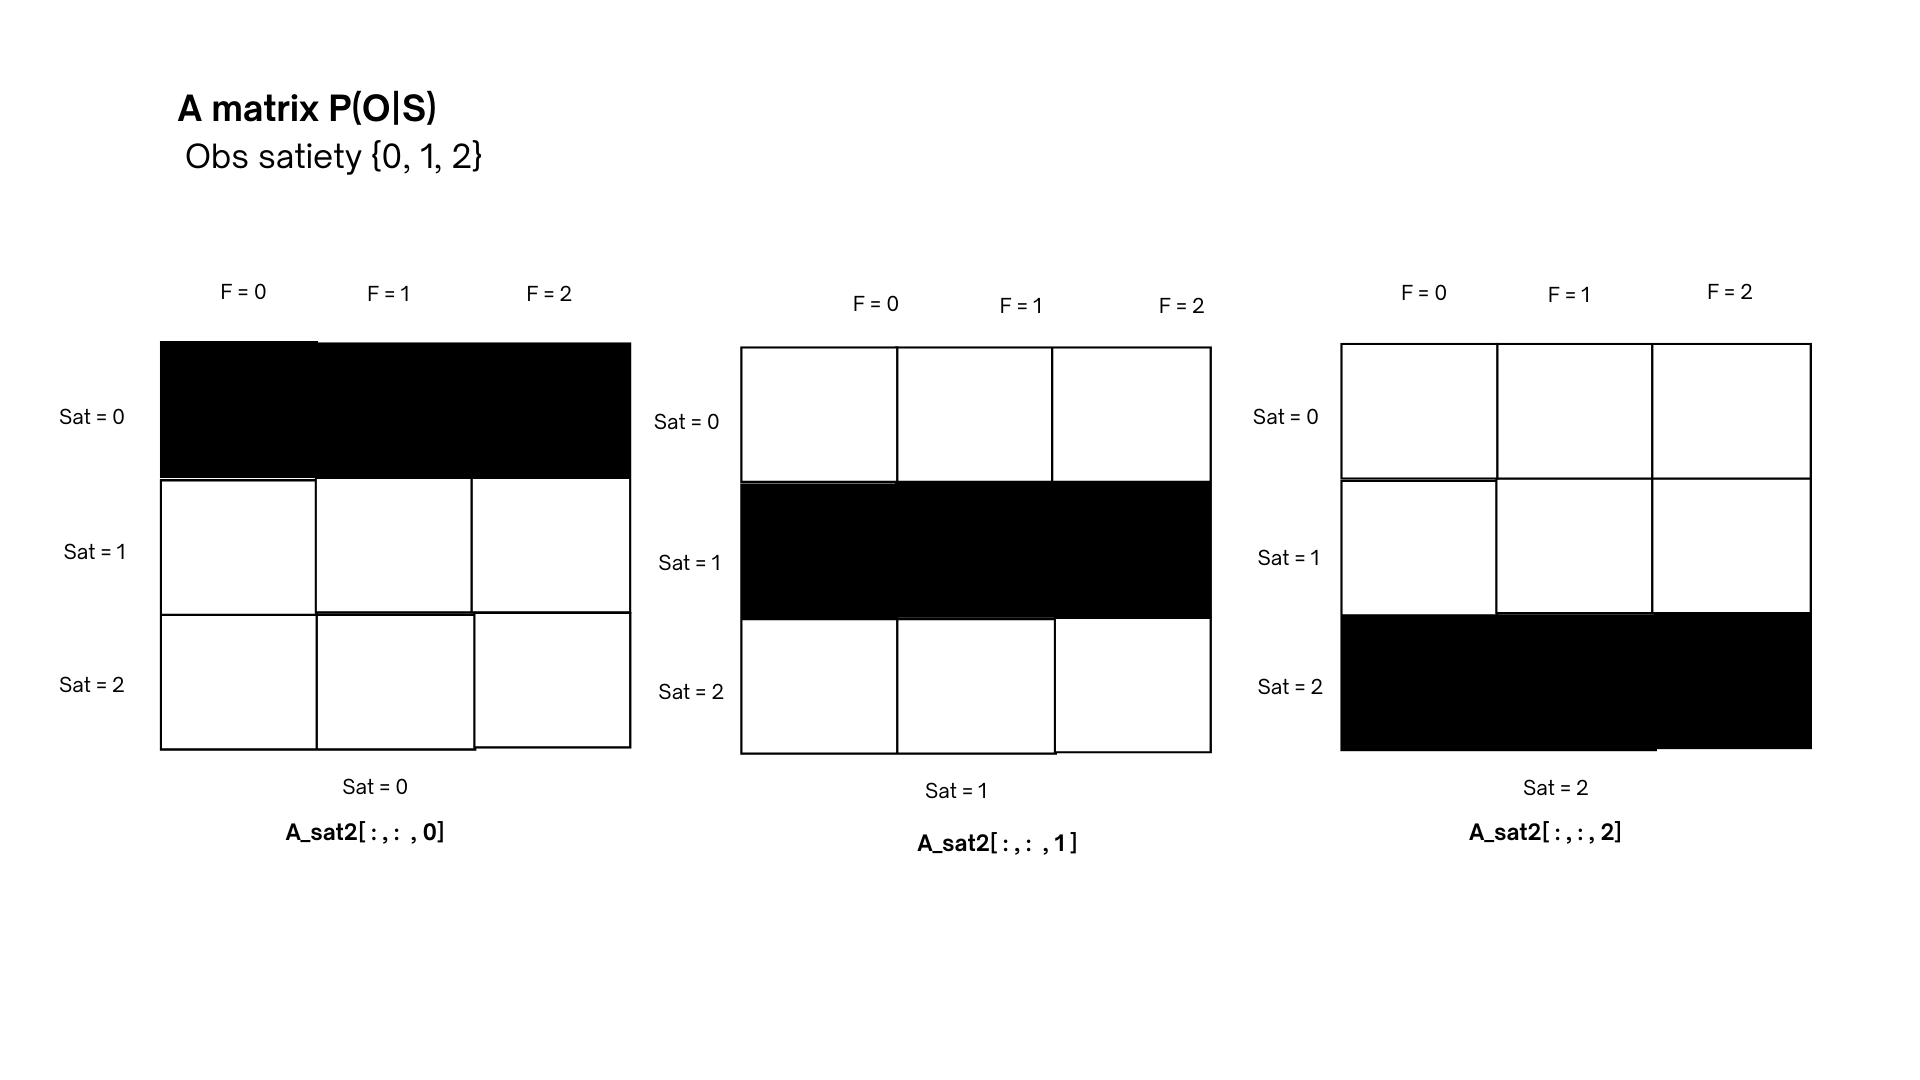

In [ ]:
A_satiety2 = np.zeros((len(obs_satiety2), len(s_food2), len(s_satiety2)))

In [ ]:
# State satiety = 0 -> A_satiety2[:,:,0]
# State satiety = 1 -> A_satiety2[:,:,1]
# State satiety = 2 -> A_satiety2[:,:,2]

# Obs satiety = 0, state food = 0/1/2, state satiety = 0
A_satiety2[0,:,0] = 1.0

A_satiety2[1,:,0] = 0.0

A_satiety2[2,:,0] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 1
A_satiety2[0,:,1] = 0.0

A_satiety2[1,:,1] = 1.0

A_satiety2[2,:,1] = 0.0

# Obs satiety = 0, state food = 0/1/2, state satiety = 2
A_satiety2[0,:,2] = 0.0

A_satiety2[1,:,2] = 0.0

A_satiety2[2,:,2] = 1.0

In [ ]:
A_satiety2.shape

(3, 3, 3)

In [ ]:
A_satiety2[:,2,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
A2[1] = A_satiety2

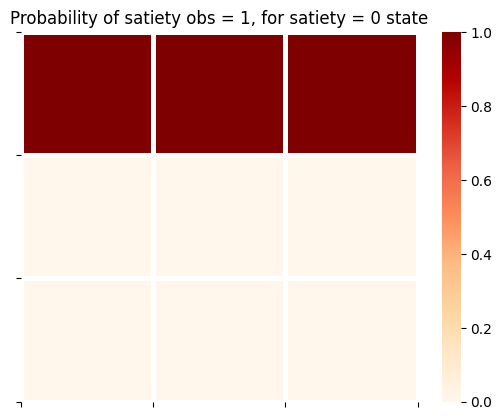

In [ ]:
utils.plot_likelihood(A2[1][:,:,0], title = 'Probability of satiety obs = 1, for satiety = 0 state')

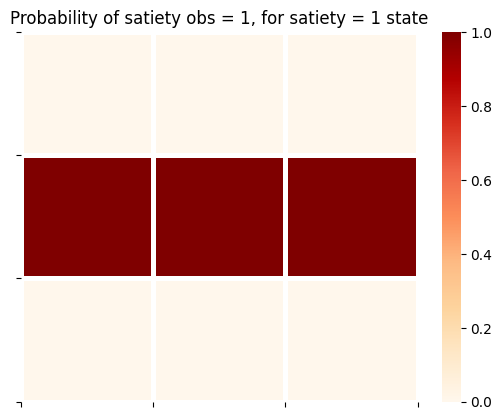

In [ ]:
utils.plot_likelihood(A2[1][:,:,1], title = 'Probability of satiety obs = 1, for satiety = 1 state')

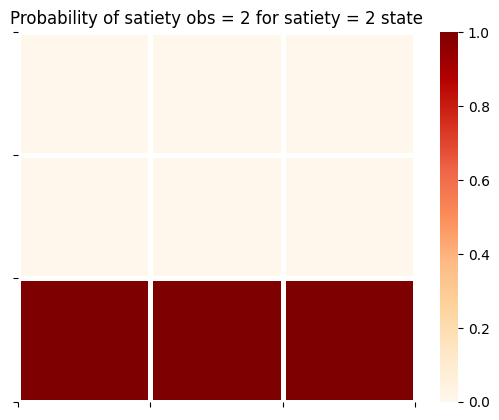

In [ ]:
utils.plot_likelihood(A2[1][:,:,2], title = 'Probability of satiety obs = 2 for satiety = 2 state')

Like above, the agent has satiety 0/1/2 when satiety state is 0/1/2, regardless food left.

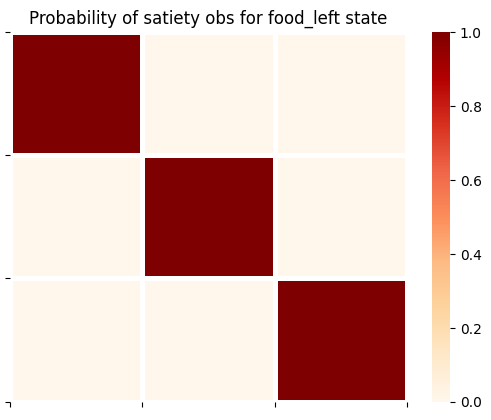

In [ ]:
utils.plot_likelihood(A2[1][:,2,:], title = 'Probability of satiety obs for food_left state')

### Transition model (Planning) - *B matrix*

B matrix is updated: eating when food is available leads to a satiated agent and no food. Not eating results in an increase of food and satiety. The agent must balance immediate satiety with long-term food availability.

In [ ]:
num_states2

[3, 3]

In [ ]:
num_controls

[2, 2]

In [ ]:
# B_factor_list says the states each state depends on
# index 1: food left state only depends on food left state [0]; index 2: satiety depends on both food left and satiety states [0,1]
B2_factor_list = [[0], [0,1]] # we add an extra dim to the matrix for satiety state

B2 = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

#### Food left state

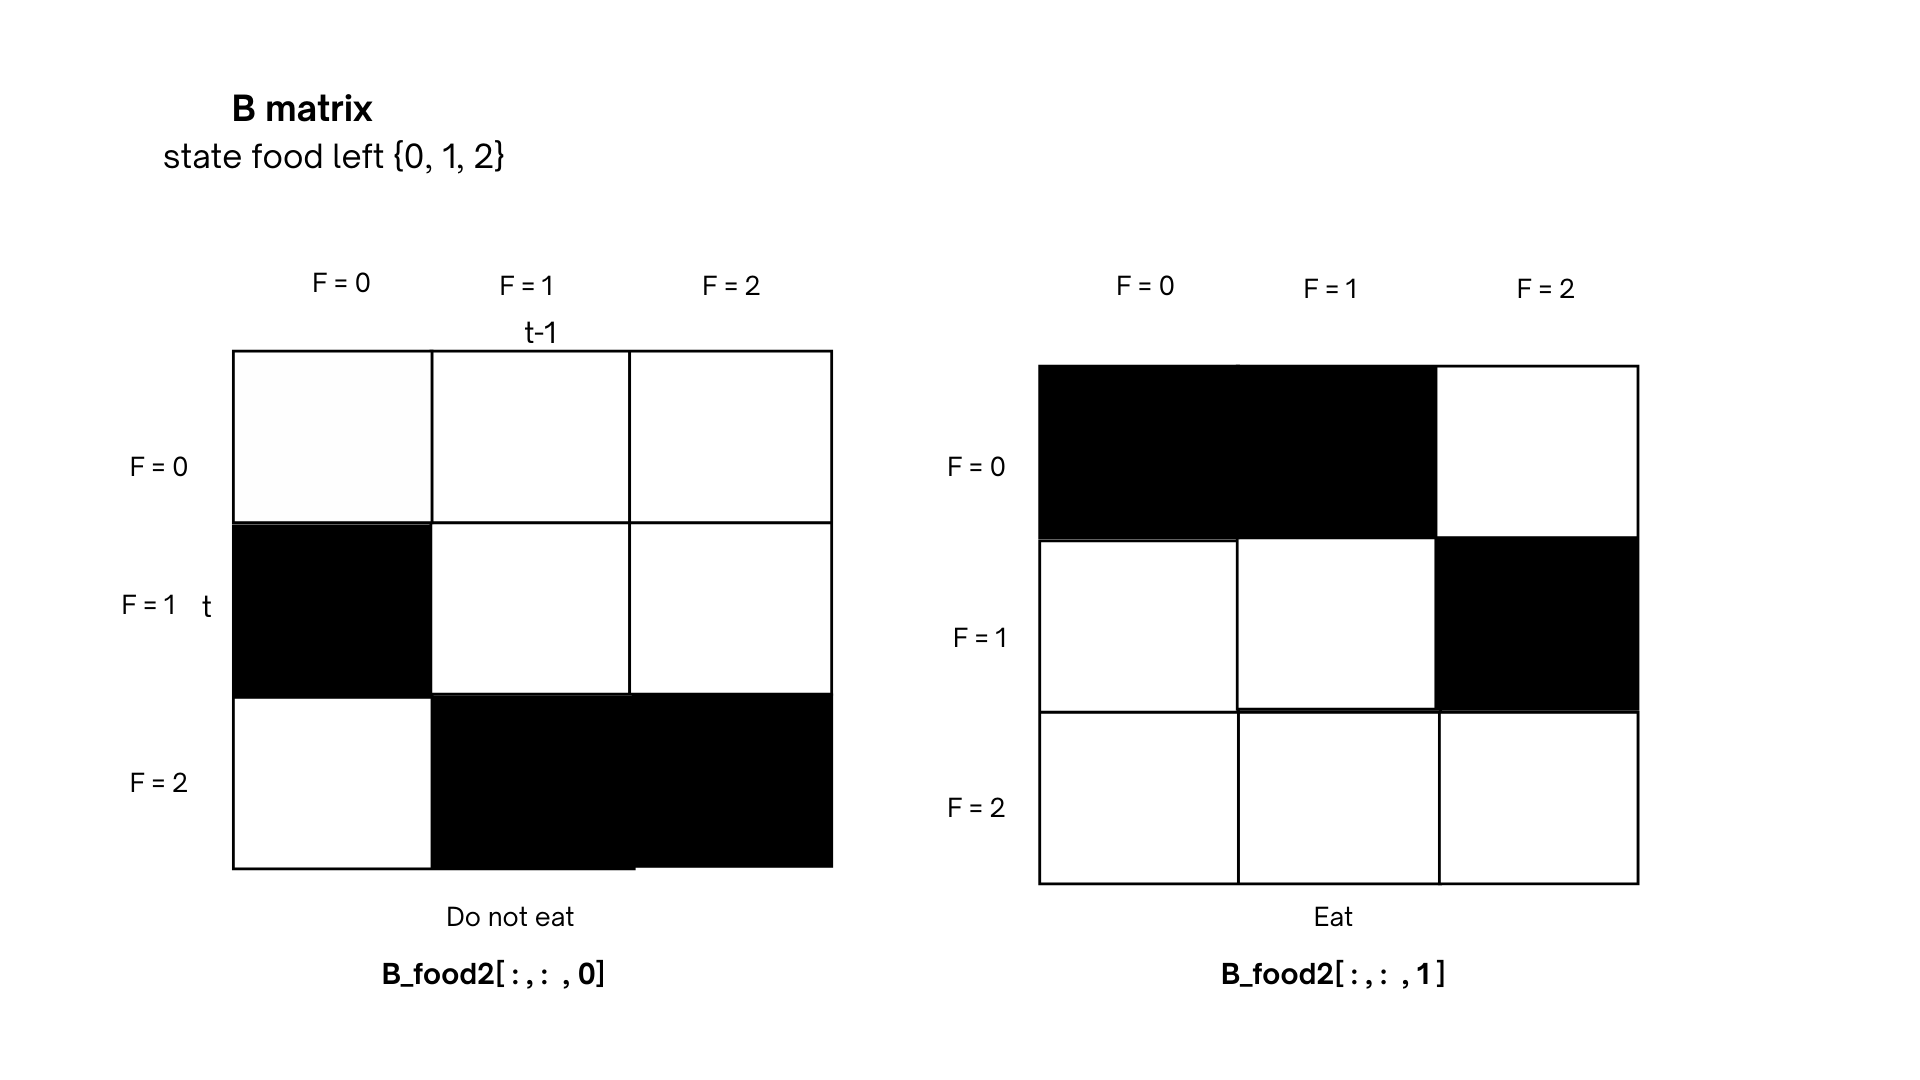

In [ ]:
B2[0].shape

(3, 3, 2)

In [ ]:
B2[0][:,:,:] = 0.0

# Action = do not eat -> B_food_left2[:,:,0]

# index 1: state t, index 2: state t-1, index 3: action

# state t: food left = 1, state t-1: food = 0, action: do not eat (0) should be 0%
B2[0][1,0,0] = 1.0

# state t: food left = 2, state t-1: food = 1, action: do not eat (0)
B2[0][2,1,0] = 1.0

# state t: food left = 2, state t-1: food = 0, action: do not eat (0)
B2[0][2,2,0] = 1.0

In [ ]:
B2[0][:,:,0]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 1.]])

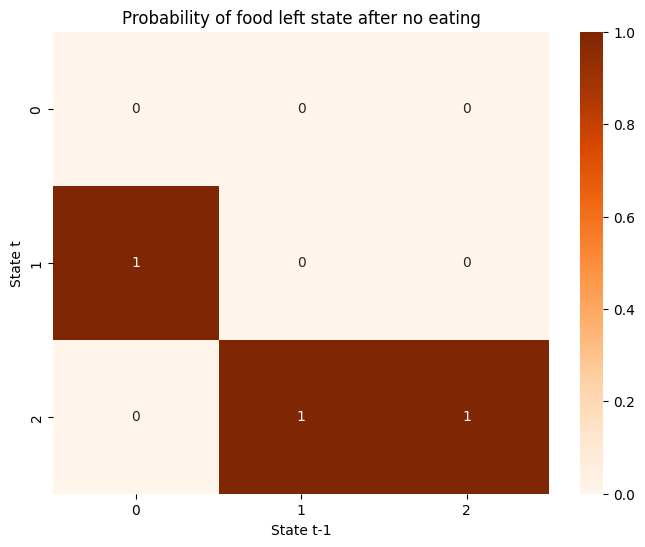

In [ ]:
plot_likelihoodB(B2[0][:,:,0], title = 'Probability of food left state after no eating' )

If the agent does not eat the food grows in time.

In [ ]:
# Action = eat -> B_food_left2[:,:,1]

B2[0][0,0,1] = 1.0
B2[0][0,1,1] = 1.0
B2[0][1,2,1] = 1.0

In [ ]:
B2[0][:,:,1]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

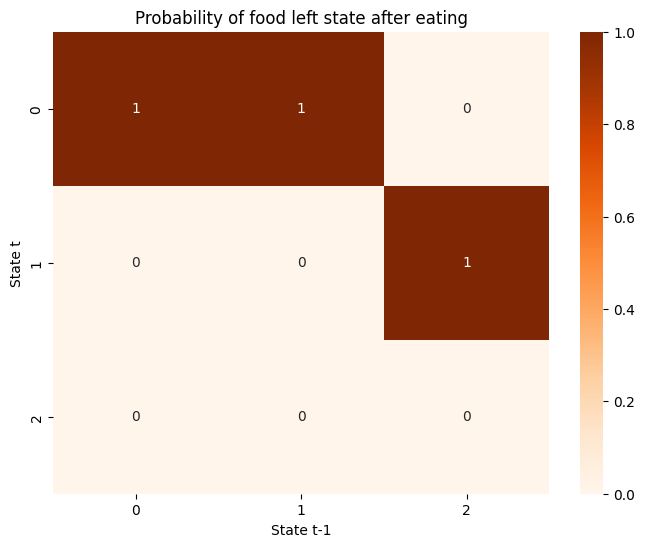

In [ ]:
plot_likelihoodB(B2[0][:,:,1], title = 'Probability of food left state after eating' )

#### Satiety state

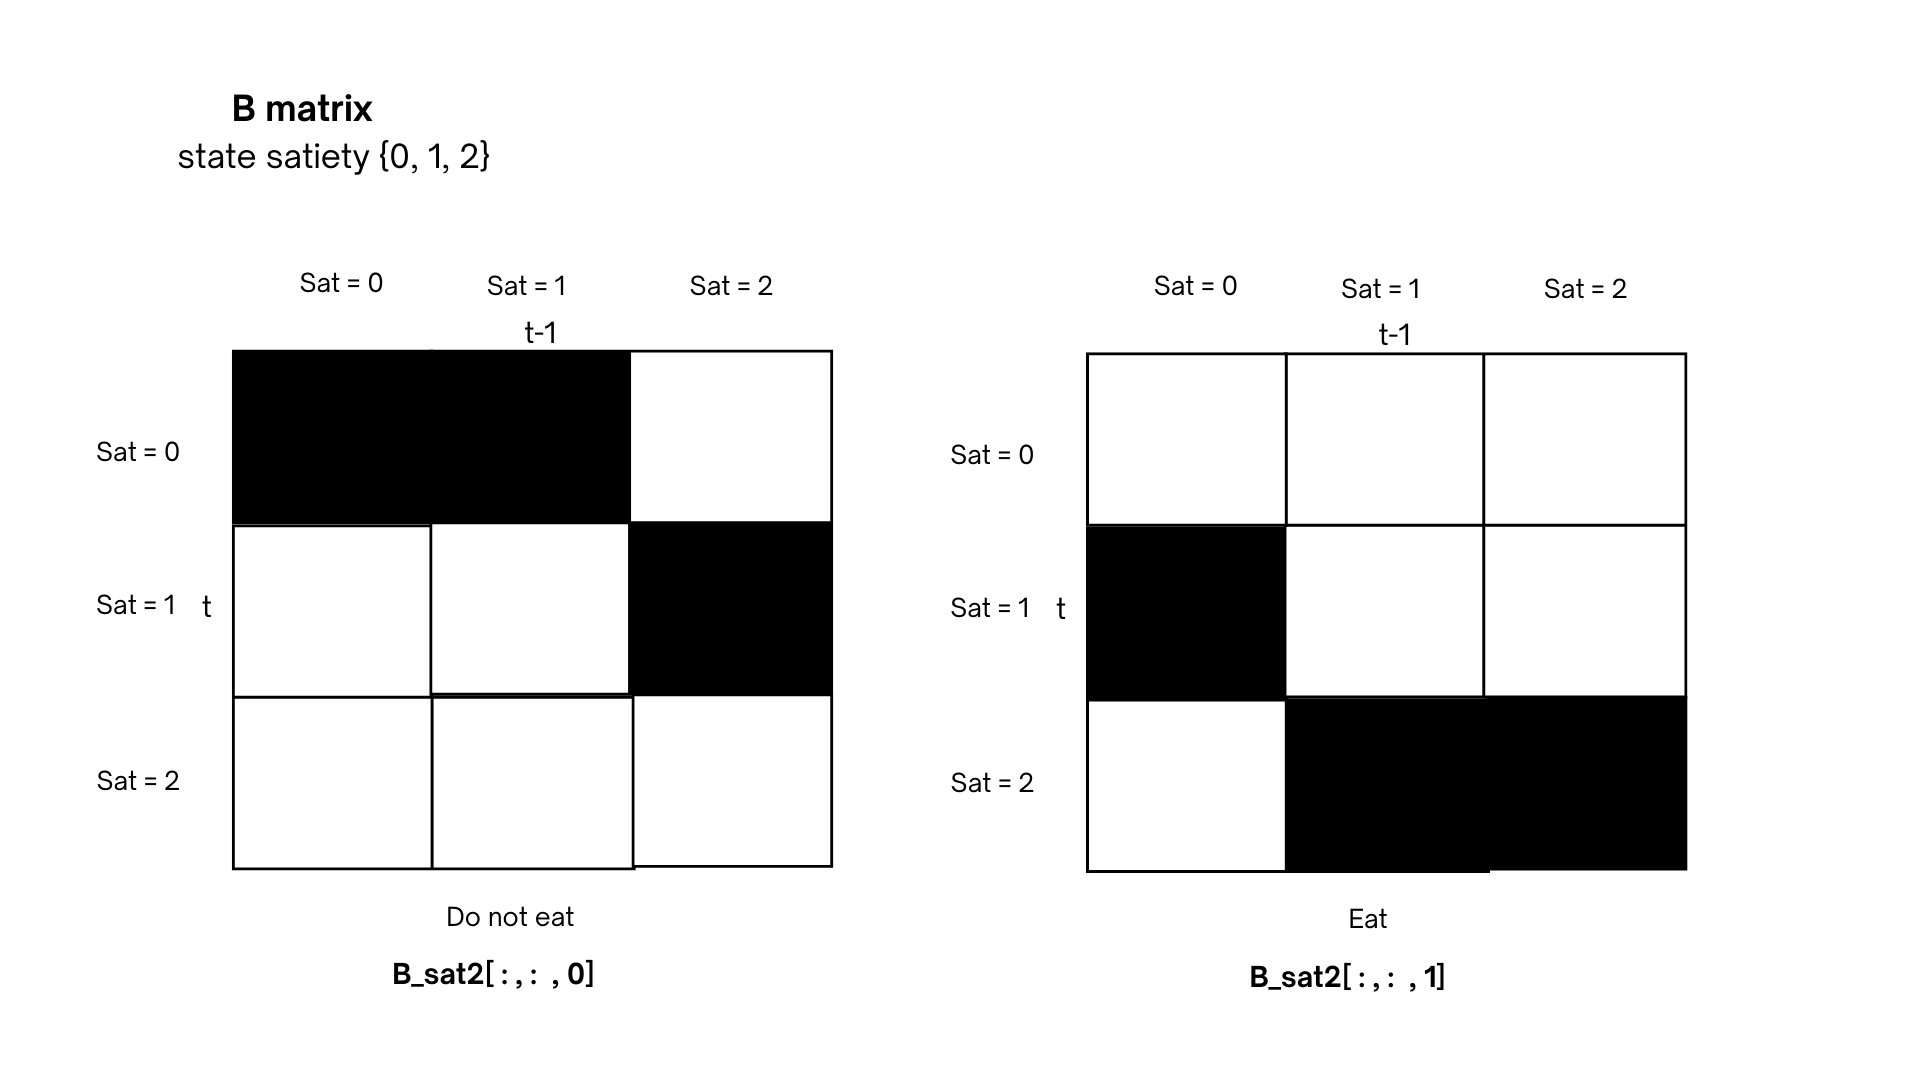

In [ ]:
# B2[1] -> satiety, has an extra dim with respect to B2[0]as set in B2_factor_list
# index 1: satiety t; index 2: food left t-1 ; index 3: satiety t-1; index 4: action

B2[1][:,:,:,:] = 0.0
print(B2[1].shape)

(3, 3, 3, 2)


In [ ]:
# Action = do not eat -> B_satiety2[:,:,:,0]
# index 1: satiety t; index 2: food left t-1; index 3: satiety t-1; index 4: action
# if the agent does not eat, regardless of food left situation, its satiety goes down by 1

B2[1][0,:,0,0] = 1.0
B2[1][0,:,1,0] = 1.0
B2[1][1,:,2,0] = 1.0

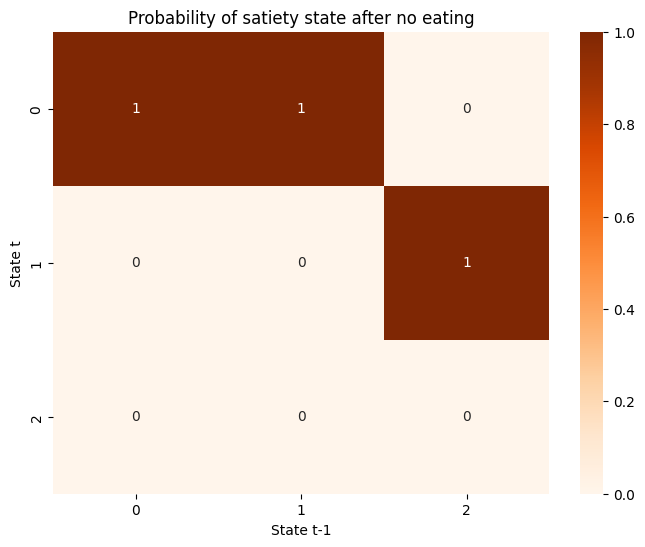

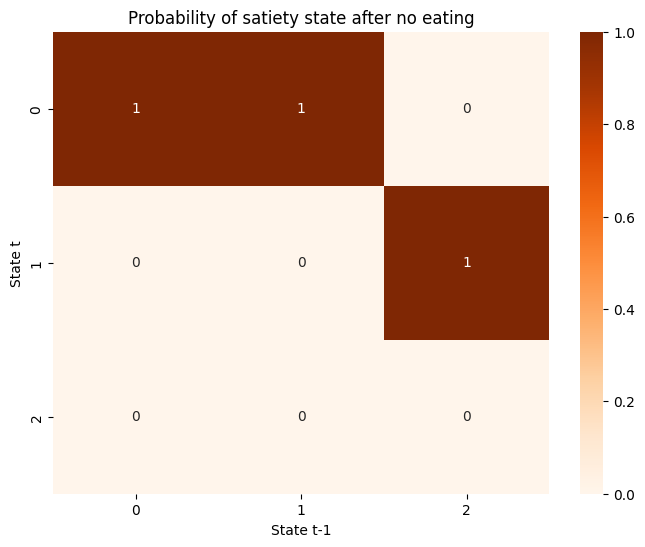

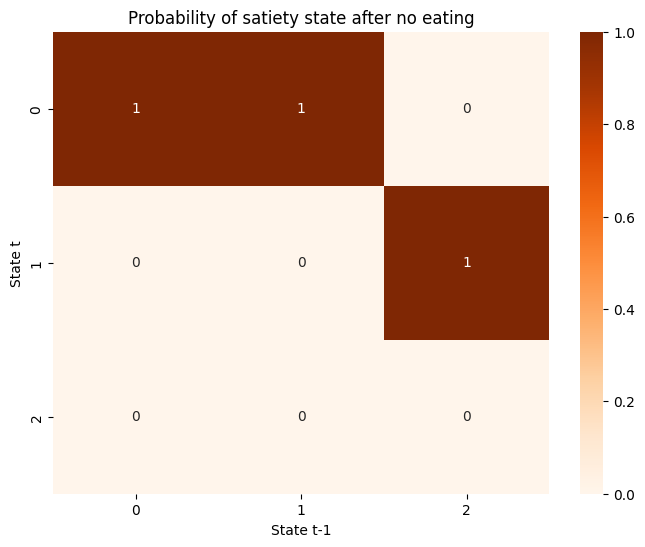

In [ ]:
plot_likelihoodB(B2[1][:,0,:,0], title = 'Probability of satiety state after no eating' )
plot_likelihoodB(B2[1][:,1,:,0], title = 'Probability of satiety state after no eating' )
plot_likelihoodB(B2[1][:,2,:,0], title = 'Probability of satiety state after no eating' )

In [ ]:
# do eat. if no food left at t-1 (index 2), then satiey will go down

B2[1][0,0,0,1]=1.0
B2[1][0,0,1,1]=1.0
B2[1][1,0,2,1]=1.0

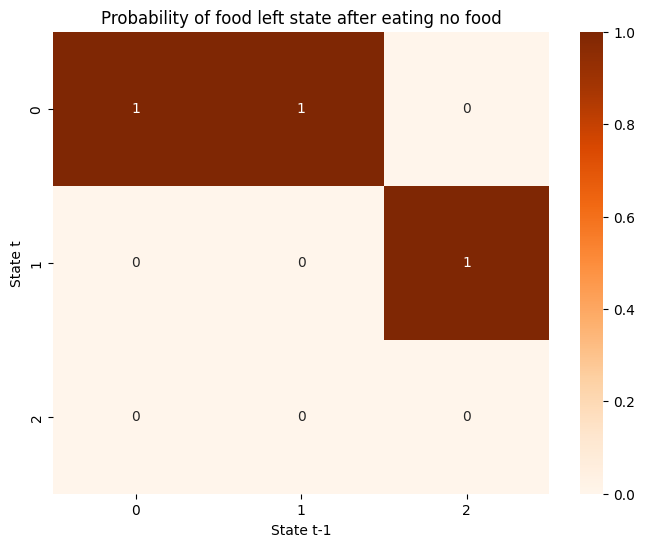

In [ ]:
plot_likelihoodB(B2[1][:,0,:,1], title = 'Probability of food left state after eating no food' )

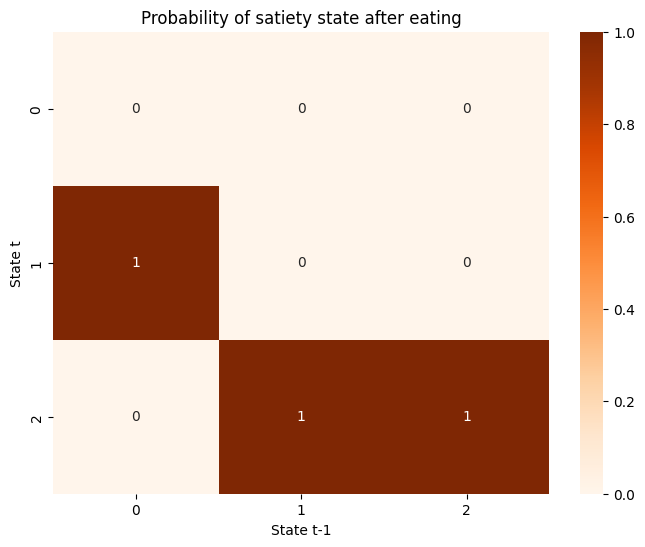

In [ ]:
# do eat. if food left then, then satiey will go up

B2[1][1,1,0,1]=1.0
B2[1][2,1,1,1]=1.0
B2[1][2,1,2,1]=1.0
plot_likelihoodB(B2[1][:,1,:,1], title = 'Probability of satiety state after eating')

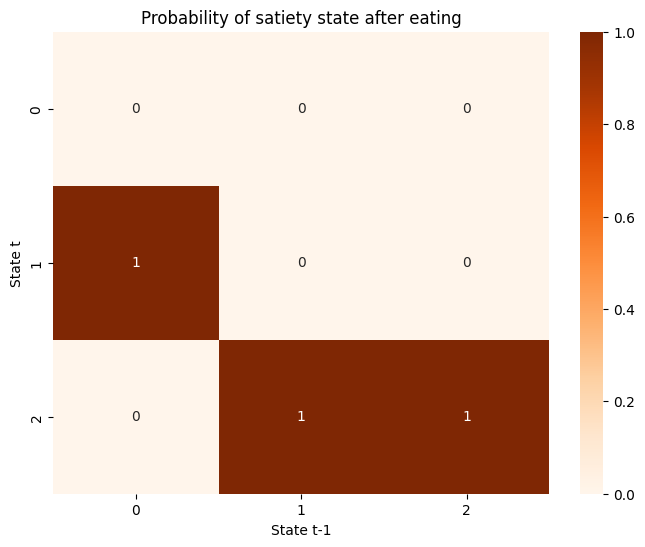

In [ ]:
B2[1][1,2,0,1]=1.0
B2[1][2,2,1,1]=1.0
B2[1][2,2,2,1]=1.0

plot_likelihoodB(B2[1][:,1,:,1], title = 'Probability of satiety state after eating' )

In [ ]:
B2[1][:,:,:,1]

array([[[1., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 1.],
        [0., 1., 1.]]])

The above matrices look all the same, because regardless of food left situation, if the agent does not eat, its satiety goes down.

In [ ]:
print("Is the B matrix normalised?", utils.is_normalized(B2))

Is the B matrix normalised? True


### Prior preferences  - *C vector*



C vector: satisfying its hunger (maximizing satiety) and maintaining a sustainable food supply. The prior preferences encoded in the C matrix influence this tradeoff.

In [ ]:
# create prior preferences over observations

C2 = utils.obj_array_zeros([num_obs2])
C2

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
# Define preferences for each observation modality

C_food_left2 = np.array([5.0, 5.0, 5.0])  # flat preference on the obs of food left
#C_food_left2 = np.array([0.0, 20.0, 0.0])  # strong preference for the observation modality of food 1 <- average value
C_satiety2 = np.array([0.0, 10.0, 20.0]) # preference for the observation modality of sat = 1 (10.0) e sat = 2 (20.0)

# create an object array to hold each modality's preferences
C2 = np.empty(2, dtype=object)
C2[0] = C_food_left2
C2[1] = C_satiety2

In [ ]:
C2

array([array([5., 5., 5.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
len(C2)

2

In [ ]:
print("C vector:", C2)
for i, pref in enumerate(C2):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([5., 5., 5.]) array([ 0., 10., 20.])]
Preferences for observation modality 0: [5. 5. 5.]
Preferences for observation modality 1: [ 0. 10. 20.]


In [ ]:
softmax(C2[1])

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

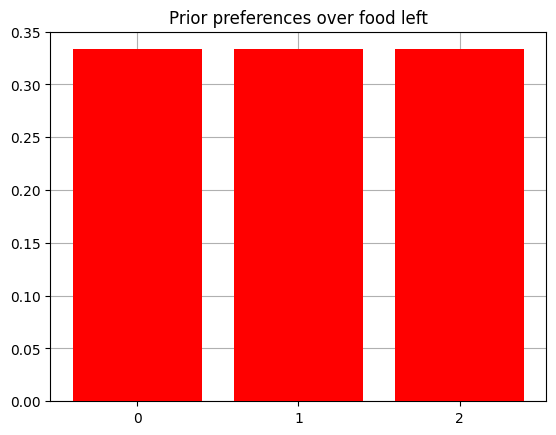

In [ ]:
utils.plot_beliefs(softmax(C2[0]), title = "Prior preferences over food left")

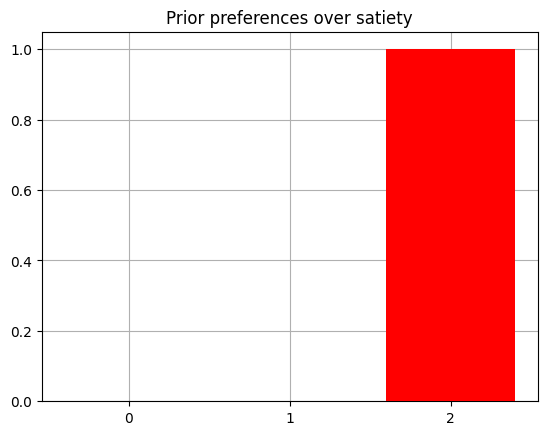

In [ ]:
utils.plot_beliefs(softmax(C2[1]), title = "Prior preferences over satiety")

Following *D vector* is superfluous/could mess things up

In [ ]:
# specify prior over hidden states (D vector)

#D2 = utils.obj_array(num_factors2)

# we set at t = 0 strong beliefs over hidden state food left = 2 D2[0][:,1,:] and satiety = 0 D2[1][0,:,:]

#D_food_left2 = np.array([0.0, 20.0, 20.0])
#D_satiety2 = np.array([20.0, 0.0, 0.0])

# create an object array to hold each modality's preferences
#D2 = np.empty(2, dtype=object)
#D2[0] = D_food_left2
#D2[1] = D_satiety2

#utils.plot_beliefs(softmax(D2[0]), title = "Initial beliefs about probability of food left state")

## **2.2 Generative Process**

### Agent

In [ ]:
# we set policy_len = 3 because in order to plan the agent needs to look further than just 1 ts
my_agent2 = Agent(A=A2, B=B2, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent2.policy_len


3

In [ ]:
 pol = my_agent2.policies

In [ ]:
 len(pol) # should be reduced to 8 policies <- 2(actions)^3(steps ahead)

64

In [ ]:
# Filter policies based on the condition action[0] == action[1], so that we have the same action for both obs for all the 3 time steps
def is_valid_policy(policy):
    return all((action[0] == action[1]) for action in policy)

restricted_policies = [policy for policy in pol if is_valid_policy(policy)]

restricted_policies

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(restricted_policies)

8

In [ ]:
my_agent2.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent2.E = my_agent2._construct_E_prior()

In [ ]:
my_agent2.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent2.policies)

8

### AIF loop

In [ ]:
class room_Env2:
    def __init__(self):

        # Initial states
        self.state_food2 = 2  # food = 2 (full)
        self.state_satiety2 = 1  # satiety = 1 (half satisfied)

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        if action == 0:  # do not eat
            # increase food level if agent does not eat
            self.state_food2 = min(self.state_food2 + 1, 2)  # food level can grow up to 2
            self.state_satiety2 = max(self.state_satiety2 - 1, 0) # satiety decreases

        elif action == 1:  # eat
            if self.state_food2 > 0:  # can only eat if food is present
                # decrease food, increase satiety
                self.state_food2 -= 1
                self.state_satiety2 = min(self.state_satiety2 + 1, 2)
            elif self.state_food2==0:
                self.state_food2 = 0
                self.state_satiety2 = min(self.state_satiety2 - 1, 2)

        # mapping states to observations
        obs_food2 = self.state_food2  # directly use the state as observation
        obs_satiety2 = self.state_satiety2

        return [obs_food2, obs_satiety2]

    def reset(self):
        # reset the environment to the initial state
        self.state_food2 = 2  # Food full present
        self.state_satiety2 = 1  # Half satisfied

        return [self.state_food2, self.state_satiety2]

We can run the AIF loop several times to show results reliability

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent2.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent2.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent2.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent2.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 2, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 3, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 4, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 5, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 6, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 7, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 8, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 9, Action taken: 1
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 2
Time step 2, Action taken: 0
Observation: [array([1]), array([1])]


In [ ]:
# to read the output: observation index 1: food left, index 2: satiety

The agent is planning with respect to the future (policy lenght is 3 ts) and it needs to care if it has food left, by not being greedy. This happens, and it manages to stay alive (satiety never goes to 0 over 10 ts for 3 runs) by not eating all the food at its disposal.

### Results plots

<ipython-input-197-60135239df0d>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors


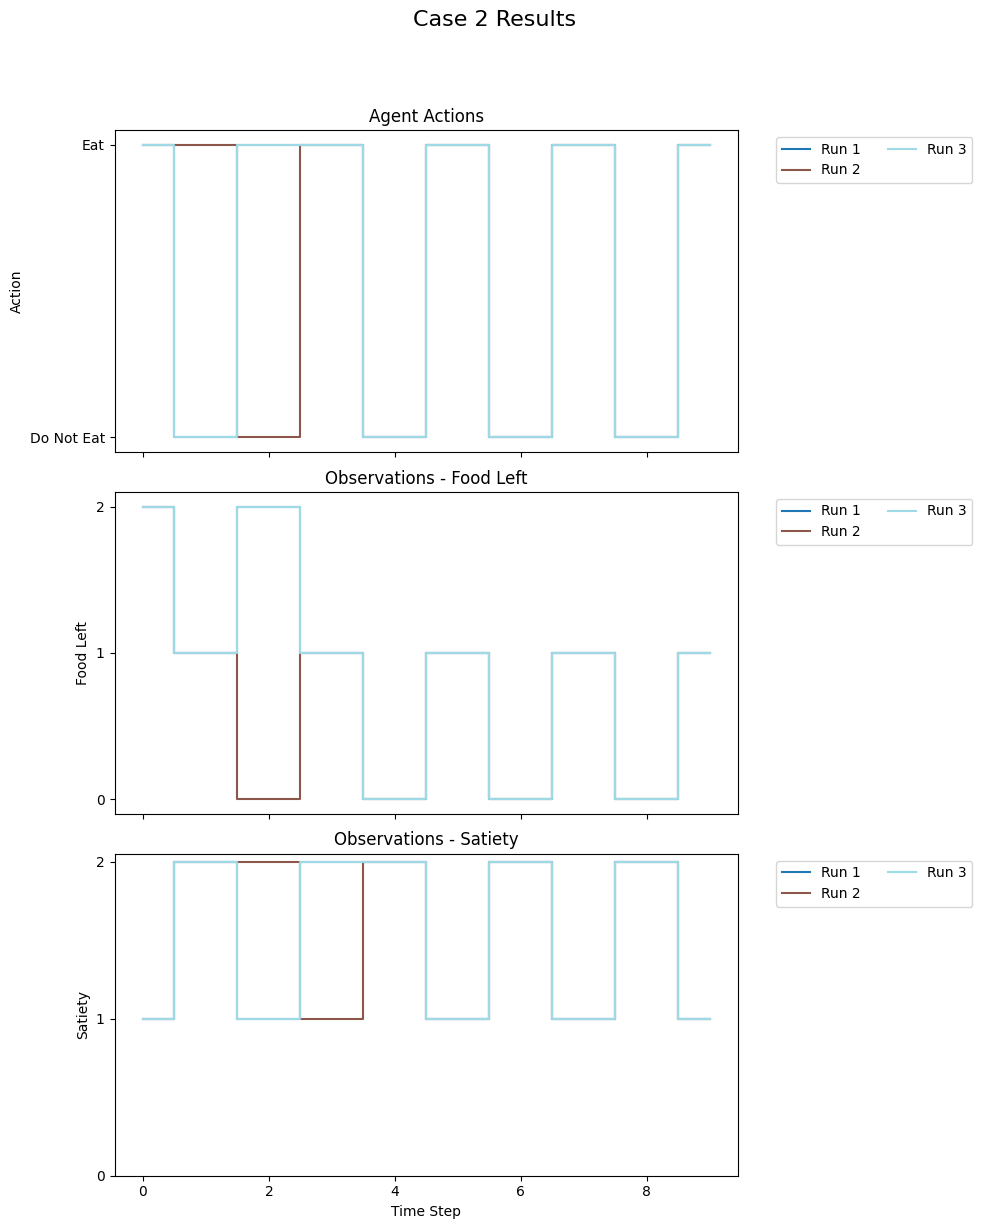

In [ ]:
from matplotlib.cm import get_cmap

# Define a colormap
cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors

# Plot the results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plotting actions for each run
for run in range(num_runs):
    axs[0].step(time_steps, actions_list[run], where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - food left for each run
for run in range(num_runs):
    obs_food = [obs[0][0] for obs in observations_list[run]]  # Extracting food left
    axs[1].step(time_steps, obs_food, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - satiety for each run
for run in range(num_runs):
    obs_satiety = [obs[1][0] for obs in observations_list[run]]  # Extracting satiety level
    axs[2].step(time_steps, obs_satiety, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 Results", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()


Run 1 completely overlaps with part of run 2 and part of run 3.

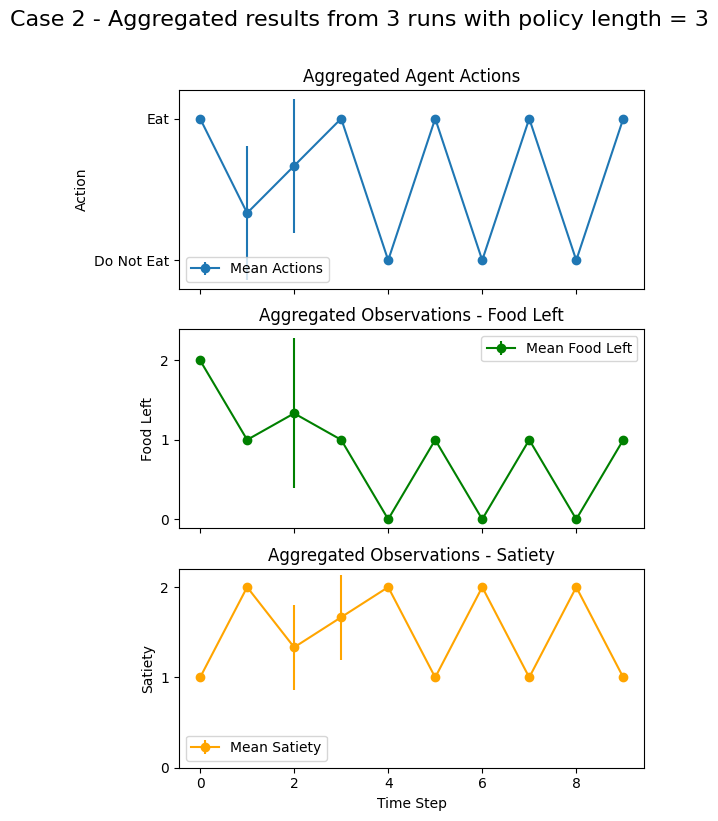

In [ ]:
# Plot the aggregated results
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with policy length = 3", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()


##**2.3 Learning** - in progress

Until now we have tested the agent's behavior to see whether it was correct. This was done by having pre-filled A and B matrices. Now, we are introducing learning of the B matrix, which represents the agent's model of how its actions affect the state of the environment. We keep the pre-filled A matrix and initialize a random B matrix to check whether the agent is able to learn the B matrix the way it should be through different runs. Focusing on the B matrix only also is useful to save computational resources and not adding too much layers of complexity.

**Expected results:** in the early runs the agent behaves randomly and dies quickly. But with learning it should improve performance and eventually learn to survive indefinitely. And it will learn the B matrix which look like the ones we hand designed.

In [ ]:
#we do not fill in the B matrix
B2_random = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

In [ ]:
B2_random[0].shape

(3, 3, 2)

In [ ]:
B2_random[1].shape

(3, 3, 3, 2)

In [ ]:
B2_random

array([array([[[0.42800686, 0.30416058],
               [0.76804499, 0.19173749],
               [0.34674719, 0.02615416]],

              [[0.26007423, 0.34147933],
               [0.15521024, 0.43461085],
               [0.21236425, 0.46752154]],

              [[0.31191891, 0.3543601 ],
               [0.07674477, 0.37365166],
               [0.44088855, 0.5063243 ]]]),
       array([[[[0.58617818, 0.36157795],
                [0.57915122, 0.33508406],
                [0.49828639, 0.50996414]],

               [[0.38141714, 0.6643012 ],
                [0.55709955, 0.01336868],
                [0.43278986, 0.54634809]],

               [[0.16441811, 0.50895293],
                [0.38948315, 0.16041291],
                [0.33499261, 0.47186836]]],


              [[[0.2290083 , 0.35126332],
                [0.04341075, 0.08848693],
                [0.42115237, 0.22513444]],

               [[0.06851144, 0.00086346],
                [0.19123998, 0.84255032],
                [0.4766051

We have a new my_agent2, with a random B matrix

In [ ]:
my_new_agent2 = Agent(A=A2, B=B2_random, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
# from Collis, Kinghorn (https://github.com/PoppyCollis/METATOOL_UoS/blob/master/agent.py)

#def update_B(self, qs_prev):

      #  Update posterior beliefs about Dirichlet parameters that parameterise the transition likelihood

 #       qB = learning.update_state_likelihood_dirichlet_interactions(
  #          self.pB,
   #         self.B,
     #       self.action,
    #      self.qs,
     #       qs_prev,
      #      self.B_factor_list,
       #     self.lr_pB,
    #        self.factors_to_learn
     #   )

     #   self.pB = qB # set new prior to posterior
     #   self.B = utils.norm_dist_obj_arr(qB)  # take expected value of posterior Dirichlet parameters to calculate posterior over B array

      #  return qB


making sure the following is well defined:

In [ ]:
def update_B2_matrix(B2_random, state_t_minus_1, state_t, action, B2_factor_list, learning_rate=0.1):
    """
    Update the B matrix based on observed transitions using a learning rate.
    :param B2_random: The current B matrix.
    :param state_t_minus_1: The state at time t-1.
    :param state_t: The state at time t.
    :param action: The action taken.
    :param factor_list: The factor list specifying dependencies between hidden state factors and actions.
    :param learning_rate: The learning rate for updating B.
    :return: The updated B matrix.
    """
    B2_updated = B2_random.copy()
    for f, factors in enumerate(B2_factor_list):
        if len(factors) == 1:

            # Single factor dependency
            B2_updated[f][state_t[f], state_t_minus_1[factors[0]], action] += learning_rate

            # Normalize the updated B matrix
            sums = B2_updated[f][:, state_t_minus_1[factors[0]], action].sum(axis=0, keepdims=True)
            B2_updated[f][:, state_t_minus_1[factors[0]], action] /= sums

        elif len(factors) == 2:

            # Two-factor dependency
            B2_updated[f][state_t[f], state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action] += learning_rate

            # Normalize the updated B matrix
            sums = B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action].sum(axis=0, keepdims=True)
            B2_updated[f][:, state_t_minus_1[factors[0]], state_t_minus_1[factors[1]], action] /= sums

    return B2_updated


In [ ]:
# Number of runs and time steps
num_runs = 3
T = 10

# Initialize lists to store results
actions_list = []
observations_list = []
B_snapshots = []

# Active inference loop
for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_new_agent2.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        # update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        # sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

        # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # Update B matrix
        B2_random = update_B2_matrix(B2_random, current_state, obs, action, B2_factor_list, learning_rate=0.1)

        # Store snapshot of B matrix for the first factor and first action
        B_snapshots.append(B2_random[0][:, :, 0].copy())

        # Move to the next state
        current_state = obs

        # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")

    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)


Run 1
Time step 0, Action taken: 1
Run 1
Time step 1, Action taken: 0
Run 1
Time step 2, Action taken: 1
Run 1
Time step 3, Action taken: 0
Run 1
Time step 4, Action taken: 1
Run 1
Time step 5, Action taken: 0
Run 1
Time step 6, Action taken: 1
Run 1
Time step 7, Action taken: 0
Run 1
Time step 8, Action taken: 1
Run 1
Time step 9, Action taken: 0
Run 2
Time step 0, Action taken: 1
Run 2
Time step 1, Action taken: 0
Run 2
Time step 2, Action taken: 1
Run 2
Time step 3, Action taken: 0
Run 2
Time step 4, Action taken: 1
Run 2
Time step 5, Action taken: 0
Run 2
Time step 6, Action taken: 1
Run 2
Time step 7, Action taken: 0
Run 2
Time step 8, Action taken: 1
Run 2
Time step 9, Action taken: 0
Run 3
Time step 0, Action taken: 1
Run 3
Time step 1, Action taken: 0
Run 3
Time step 2, Action taken: 1
Run 3
Time step 3, Action taken: 0
Run 3
Time step 4, Action taken: 1
Run 3
Time step 5, Action taken: 1
Run 3
Time step 6, Action taken: 0
Run 3
Time step 7, Action taken: 1
Run 3
Time step 8, A

<ipython-input-240-9fd51bdecff3>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors


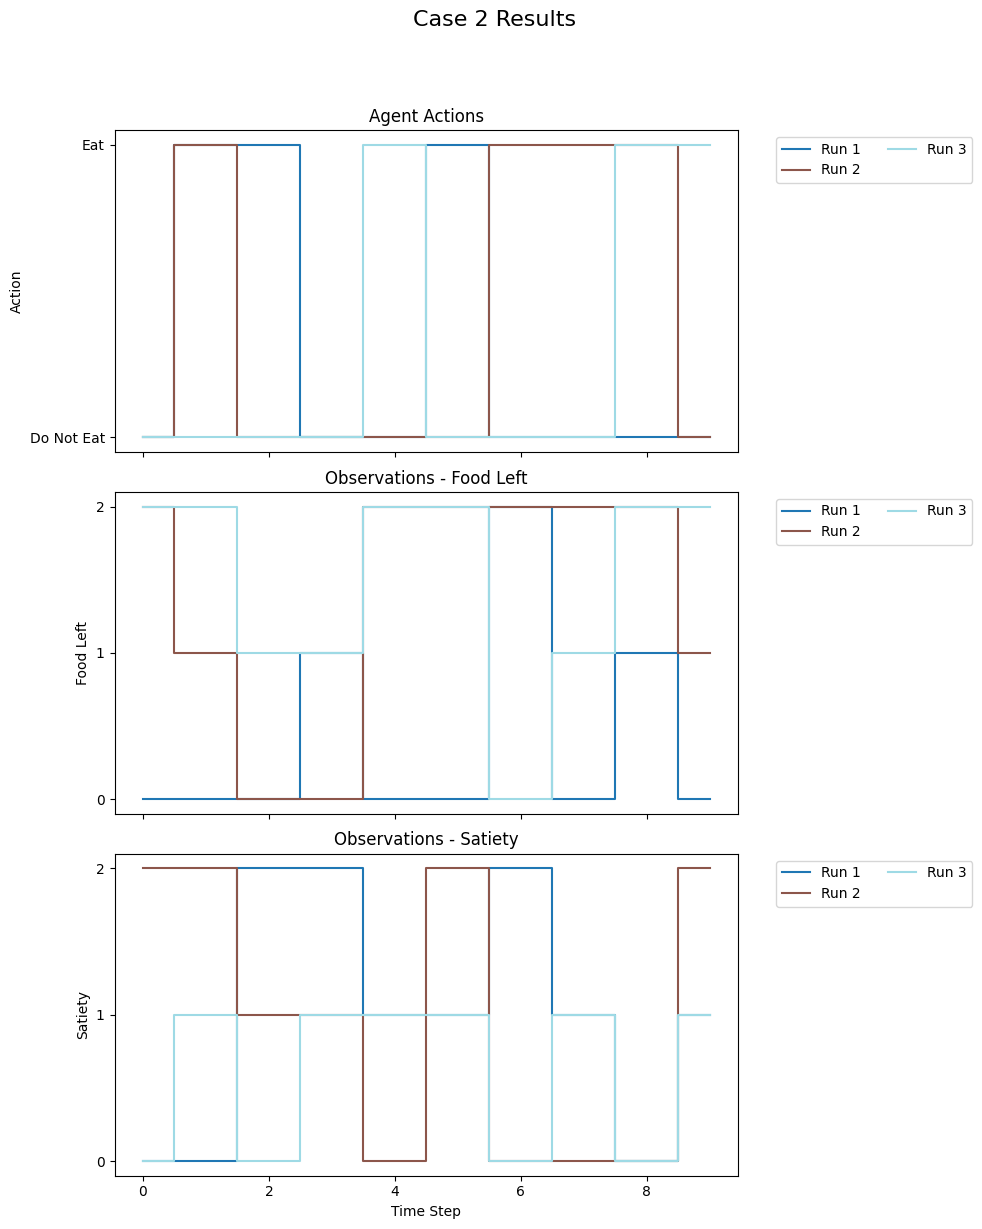

In [ ]:
num_runs = 3
T = 10

# Define a colormap
cmap = get_cmap('tab20', num_runs)  # 'tab20' provides 20 different colors

# Plotting the results for individual runs
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plotting actions for each run
for run in range(num_runs):
    axs[0].step(time_steps, actions_list[run], where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[0].set_ylabel("Action")
axs[0].set_title("Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - food left for each run
for run in range(num_runs):
    obs_food = [obs[0] for obs in observations_list[run]]  # Extracting food left
    axs[1].step(time_steps, obs_food, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[1].set_ylabel("Food Left")
axs[1].set_title("Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting observations - satiety for each run
for run in range(num_runs):
    obs_satiety = [obs[1] for obs in observations_list[run]]  # Extracting satiety level
    axs[2].step(time_steps, obs_satiety, where='mid', label=f'Run {run + 1}', color=cmap(run))
axs[2].set_ylabel("Satiety")
axs[2].set_title("Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 Results", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

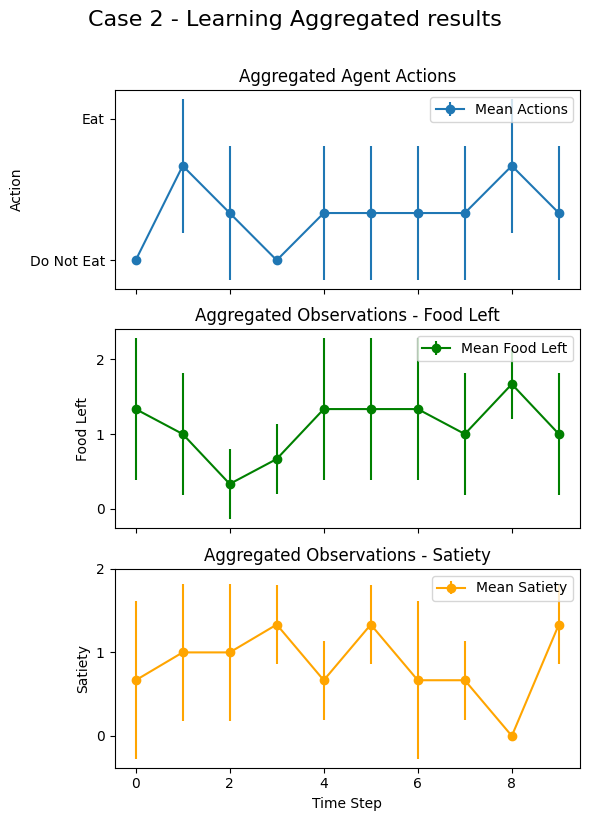

In [ ]:
# Aggregate results
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Learning Aggregated results", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()


**Plots of updating matrices**

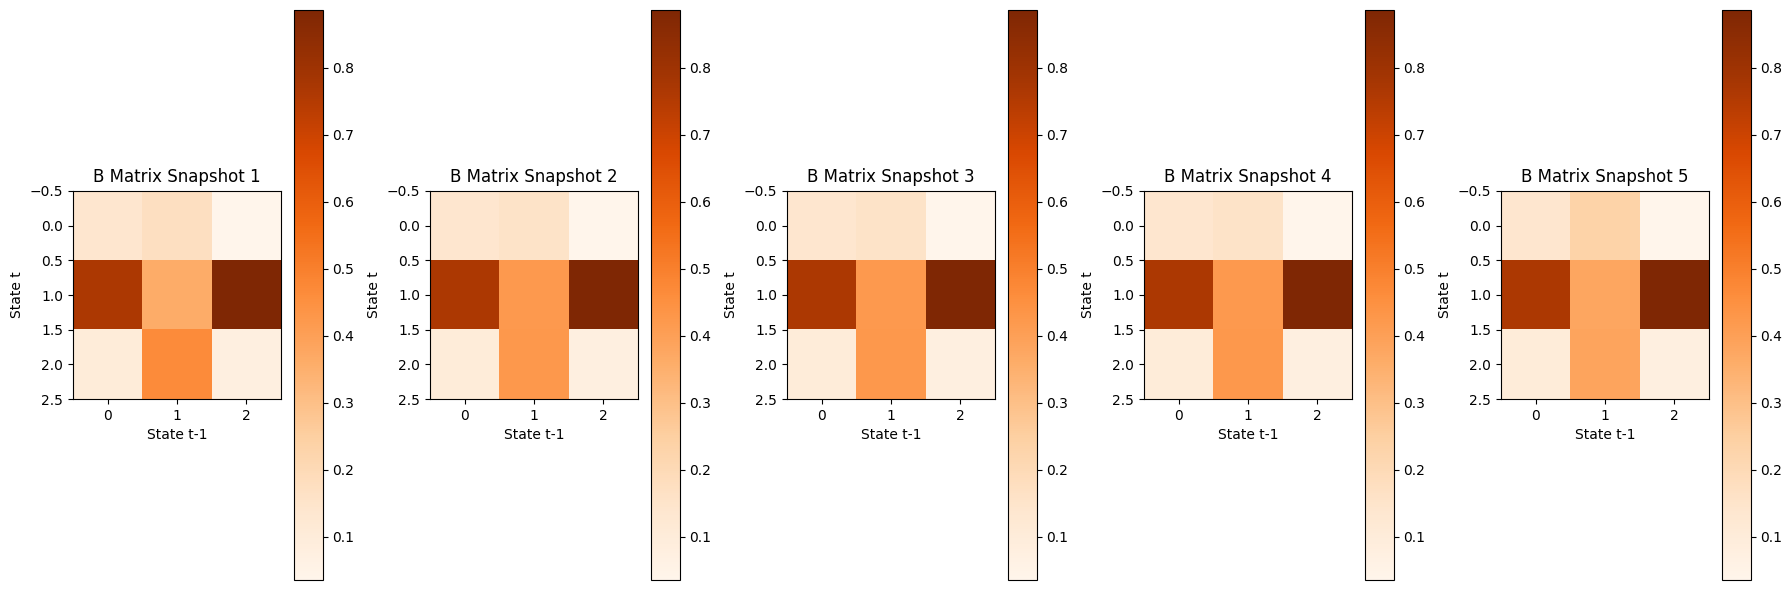

In [ ]:

# Plot snapshots of the updated B matrix for one of the factors as an example
num_snapshots = min(len(B_snapshots), 5)  # Limit to 5 snapshots for clarity

plt.figure(figsize=(18, 6))
for i in range(num_snapshots):
    plt.subplot(1, num_snapshots, i + 1)
    plt.imshow(B_snapshots[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title(f'B Matrix Snapshot {i+1}')
    plt.xlabel('State t-1')
    plt.ylabel('State t')

plt.tight_layout()
plt.show()

Something wrong: matrices are all the same

**Plots of aggregated results**

<ipython-input-238-1794d644e9dc>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


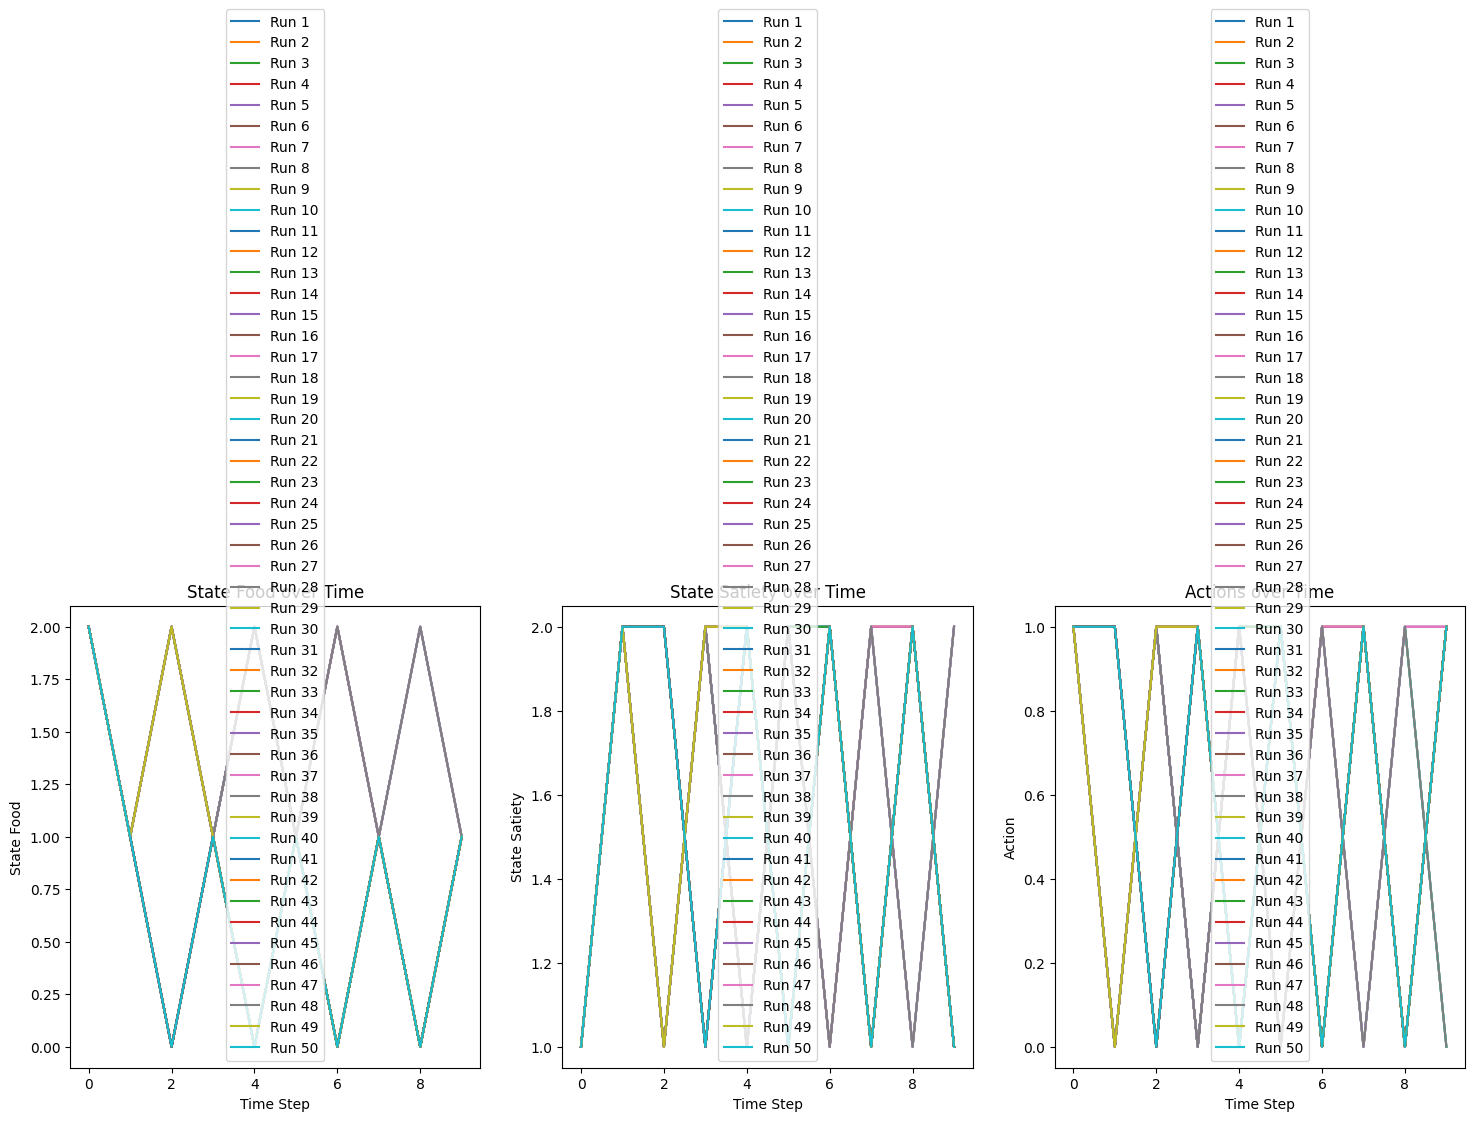

In [ ]:
# Plot aggregated results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
for run in range(num_runs):
    plt.plot(range(len(observations_list[run])), [obs[0][0] for obs in observations_list[run]], label=f'Run {run+1}')
plt.xlabel('Time Step')
plt.ylabel('State Food')
plt.title('State Food over Time')
plt.legend()

plt.subplot(1, 3, 2)
for run in range(num_runs):
    plt.plot(range(len(observations_list[run])), [obs[1][0] for obs in observations_list[run]], label=f'Run {run+1}')
plt.xlabel('Time Step')
plt.ylabel('State Satiety')
plt.title('State Satiety over Time')
plt.legend()

plt.subplot(1, 3, 3)
for run in range(num_runs):
    plt.plot(range(len(actions_list[run])), actions_list[run], label=f'Run {run+1}')
plt.xlabel('Time Step')
plt.ylabel('Action')
plt.title('Actions over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Number of runs and time steps
num_runs = 50
T = 10

# Initialize lists to store results
actions_list = []
observations_list = []
B_snapshots = []

# Active inference loop
for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent2.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        # update the agent's belief about the current state based on the observation
        qs = my_agent2.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent2.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent2.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

        # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # Update B matrix
        B2_random = update_B2_matrix(B2_random, current_state, obs, action, B2_factor_list, learning_rate=0.1)

        # Store snapshot of B matrix for the first factor and first action
        B_snapshots.append(B2_random[0][:, :, 0].copy())

        # Move to the next state
        current_state = obs

        # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")

    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

# Convert history to numpy arrays for easy plotting
actions_list = np.array(actions_list)
observations_list = np.array(observations_list)

Run 1
Time step 0, Action taken: 1
Run 1
Time step 1, Action taken: 0
Run 1
Time step 2, Action taken: 1
Run 1
Time step 3, Action taken: 1
Run 1
Time step 4, Action taken: 0
Run 1
Time step 5, Action taken: 1
Run 1
Time step 6, Action taken: 0
Run 1
Time step 7, Action taken: 1
Run 1
Time step 8, Action taken: 0
Run 1
Time step 9, Action taken: 1
Run 2
Time step 0, Action taken: 1
Run 2
Time step 1, Action taken: 1
Run 2
Time step 2, Action taken: 0
Run 2
Time step 3, Action taken: 1
Run 2
Time step 4, Action taken: 0
Run 2
Time step 5, Action taken: 1
Run 2
Time step 6, Action taken: 0
Run 2
Time step 7, Action taken: 1
Run 2
Time step 8, Action taken: 0
Run 2
Time step 9, Action taken: 1
Run 3
Time step 0, Action taken: 1
Run 3
Time step 1, Action taken: 1
Run 3
Time step 2, Action taken: 0
Run 3
Time step 3, Action taken: 1
Run 3
Time step 4, Action taken: 0
Run 3
Time step 5, Action taken: 1
Run 3
Time step 6, Action taken: 0
Run 3
Time step 7, Action taken: 1
Run 3
Time step 8, A

**Plot of updating matrices**

**Plot of aggregated resuls for fifty runs**

Or we can define the updating of the B matrix with Dirichlet, which is a more statistically robust method for learning transition probabilities based on observed data.



In [ ]:
def update_B2_matrix_with_dirichlet(agent, qs_prev):
    """
    Update the B matrix using Dirichlet parameter updates.

    Parameters
    -----------
    agent: The agent object containing B and pB matrices.
    qs_prev: 1D numpy.ndarray or numpy.ndarray of dtype object
        Marginal posterior beliefs over hidden states at previous timepoint.

    Returns
    -----------
    qB: numpy.ndarray of dtype object
        Posterior Dirichlet parameters over transition model (same shape as B), after having updated it with state beliefs and actions.
    """
    qB = learning.update_state_likelihood_dirichlet_interactions(
        agent.pB,
        agent.B,
        agent.action,
        agent.qs,
        qs_prev,
        agent.B_factor_list,
        agent.lr_pB,
        agent.factors_to_learn
    )

    agent.pB = qB  # set new prior to posterior
    agent.B = utils.norm_dist_obj_arr(qB)  # take expected value of posterior Dirichlet parameters to calculate posterior over B array

    return qB

In [ ]:
# Number of runs and time steps
num_runs = 3
T = 10

actions_list = []
observations_list = []
B_snapshots = []  # List to store B matrix snapshots

for run in range(num_runs):
    actions = []
    observations = []
    B_run_snapshots = []  # Store B snapshots for this run

    env = room_Env2()
    current_state = env.reset()
    my_new_agent2.reset()

    satiety_zero_count = 0

    for t in range(T):
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

            # Update the B matrix based on observed transition
            qs_prev = previous_qs.copy()  # Ensure you have the previous state beliefs
            state_t_minus_1 = [previous_observation[0][0], previous_observation[1][0]]  # Ensure proper state format
            state_t = [obs[0][0], obs[1][0]]  # Ensure proper state format

            # Update B matrix using Dirichlet parameters
            update_B2_matrix_with_dirichlet(my_new_agent2, qs_prev)

            # Debug print after update
            print(f"Updated B matrix snapshot:")
            print(my_new_agent2.B[0][:, :, 1])  # Check the specific slice being updated

            # Save the B matrix snapshot after update
            B_run_snapshots.append(my_new_agent2.B.copy())

        print(f"Observation: {observation}")
        print()

        # Update the agent's belief about the current state based on the observation
        qs = my_new_agent2.infer_states(observation)

        # Infer policies based on the updated beliefs
        my_new_agent2.infer_policies()

        # Sample the next action from the inferred policies
        action = my_new_agent2.sample_action()

        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])
        else:
            print("Unexpected action format. Terminating loop.")
            break

        if observation[1][0] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

        if satiety_zero_count >= 1:  # like before, agent dies if satiety = 0 last more than 1 ts
            print(f"AGENT DIED OF STARVATION IN RUN {run + 1}.")
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)

        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")

        actions.append(action)
        observations.append(observation)
        previous_observation = observation
        previous_qs = qs.copy()  # Save current state beliefs for the next iteration

    # store results for this run
    actions_list.append(actions)
    observations_list.append(observations)
    B_snapshots.append(B_run_snapshots)  # Save the snapshots for this run


Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 0


TypeError: 'int' object is not subscriptable

## **2.4 Extending results** - *in progress - no learning at the moment*

### *2.4.1 Wrong matrices*

**Transition model (Planning) - B matrix**

We set a wrong B matrix that maps different food transitions.

In [ ]:
# we set a wrong B2[1] matrix for satiety state to see if the agent learns to behave correctly despite them

In [ ]:
B2_factor_list = [[0], [0,1]] # we add an extra dim to the matrix for satiety state

B3 = utils.random_B_matrix(num_states2, num_controls, B2_factor_list)

In [ ]:
B3[0] = np.copy(B2[0])

In [ ]:
B3[0].shape

(3, 3, 2)

In [ ]:
B3[0]

array([[[0., 1.],
        [0., 1.],
        [0., 0.]],

       [[1., 0.],
        [0., 0.],
        [0., 1.]],

       [[0., 0.],
        [1., 0.],
        [1., 0.]]])

In [ ]:
B3[0][:,:,0]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 1.]])

In [ ]:
B3[0][:,:,1]

array([[1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [ ]:
B3[1].shape

(3, 3, 3, 2)

In [ ]:
B3[1][:,:,:,:] = 0.0

B3[1][0,0,:,0] = 1.0
B3[1][0,1,:,0] = 1.0
B3[1][1,2,:,0] = 1.0

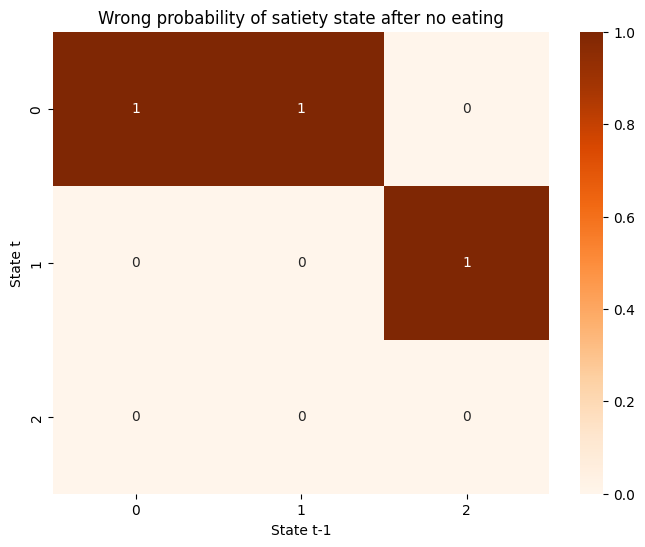

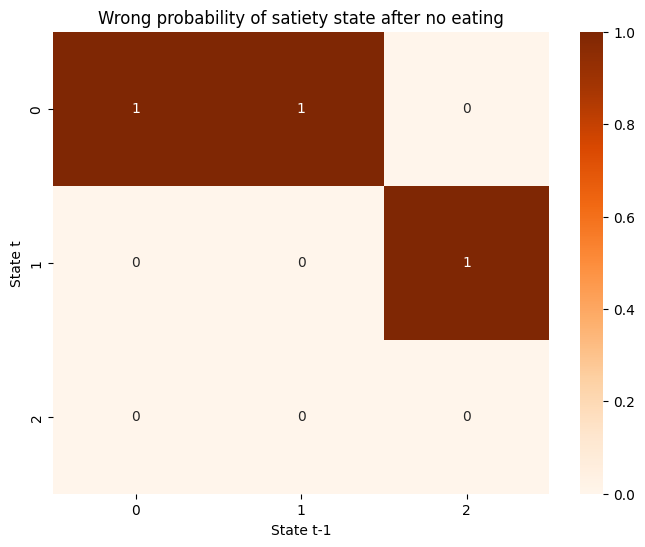

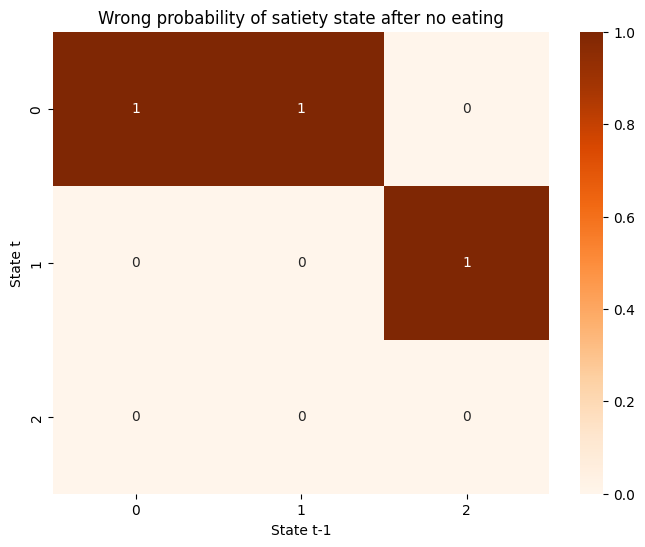

In [ ]:
plot_likelihoodB(B3[1][:,:,0,0], title = 'Wrong probability of satiety state after no eating' )
plot_likelihoodB(B3[1][:,:,1,0], title = 'Wrong probability of satiety state after no eating' )
plot_likelihoodB(B3[1][:,:,2,0], title = 'Wrong probability of satiety state after no eating' )

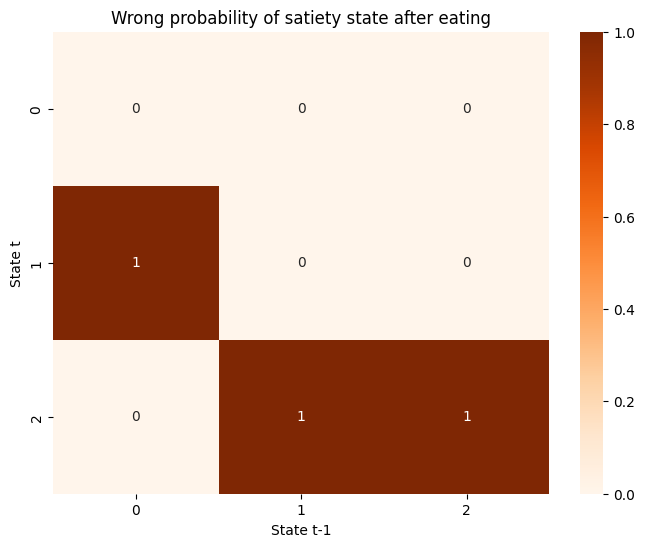

In [ ]:
B3[1][1,0,0,1]=1.0
B3[1][1,1,0,1]=1.0
B3[1][1,2,0,1]=1.0

B3[1][1,0,1,1]=1.0
B3[1][2,1,1,1]=1.0
B3[1][2,2,1,1]=1.0

B3[1][2,0,2,1]=1.0
B3[1][2,1,2,1]=1.0
B3[1][2,2,2,1]=1.0

plot_likelihoodB(B3[1][:,:,1,1], title = 'Wrong probability of satiety state after eating')

In [ ]:
B3[1][:,:,:,0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
B3[1][:,:,:,1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 1., 1.],
        [0., 1., 1.]]])

In [ ]:
# check if the matrix is normalised
# Sum the probabilities across the first axis (observation probabilities for each state)
sums = B3.sum(axis=0)
sums = B3[1].sum(axis=0)

# Check if all sums are close to 1.0
if np.allclose(sums, 1.0):
    print("The matrix is properly normalised.")
else:
    print("The matrix is not normalised. Sums:", sums)

print("Is the B matrix normalised?", utils.is_normalized(B3))

The matrix is properly normalised.
Is the B matrix normalised? True


In [ ]:
# we set policy_len = 3 because in order to plan the agent need to look further than just 1 ts
my_agent3 = Agent(A=A2, B=B3, C=C2, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent3.policy_len


3

In [ ]:
my_agent3.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent3.E = my_agent3._construct_E_prior()

In [ ]:
len(my_agent3.policies) # 8 policies expected

8

**AIF loop**

We change the agent in the AIF loop.

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent3.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent3.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent3.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent3.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 2, Action taken: 1
Observation: [array([0]), array([1])]

Run 1
Time step 3, Action taken: 1
Observation: [array([0]), array([0])]

AGENT DIES OF STARVATION.

Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 2
Time step 2, Action taken: 1
Observation: [array([0]), array([1])]

Run 2
Time step 3, Action taken: 1
Observation: [array([0]), array([0])]

AGENT DIES OF STARVATION.

Observation: [array([2]), array([1])]

Run 3
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 3
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 3
Time step 2, Action taken: 1
Observation: [array([0]), array([1])]

Run 3
Time step

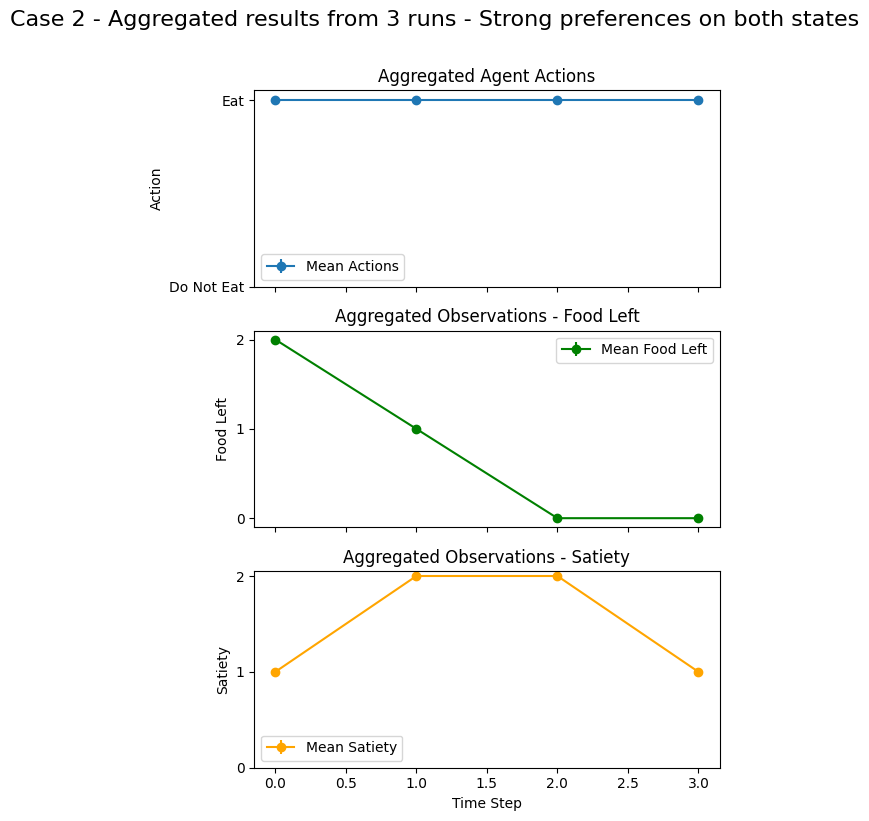

In [ ]:
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs - Strong preferences on both states", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

By setting wrong B matrix the agent does not survive more than 3 time steps for each run.

### *2.4.2 Different prior preferences*
Now we set an agent that has a strong preference for food present, while before it did not care about that.

In [ ]:
# create prior preferences over observations

C3 = utils.obj_array_zeros([num_obs2])
C3

array([array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]])], dtype=object)

In [ ]:
# Define preferences for each observation modality

C_food_left3 = np.array([0.0, 20.0, 0.0])  # strong preference for the observation modality of food 1 <- average value


# create an object array to hold each modality's preferences
C3 = np.empty(2, dtype=object)
C3[0] = C_food_left2
C3[1] = C_satiety2 #preferences over satiety are the same as before

In [ ]:
C3

array([array([5., 5., 5.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
len(C3)

2

In [ ]:
print("C vector:", C3)
for i, pref in enumerate(C3):
    print(f"Preferences for observation modality {i}: {pref}") #modality 0: food_left, 1: satiety

C vector: [array([5., 5., 5.]) array([ 0., 10., 20.])]
Preferences for observation modality 0: [5. 5. 5.]
Preferences for observation modality 1: [ 0. 10. 20.]


In [ ]:
softmax(C3[1])

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

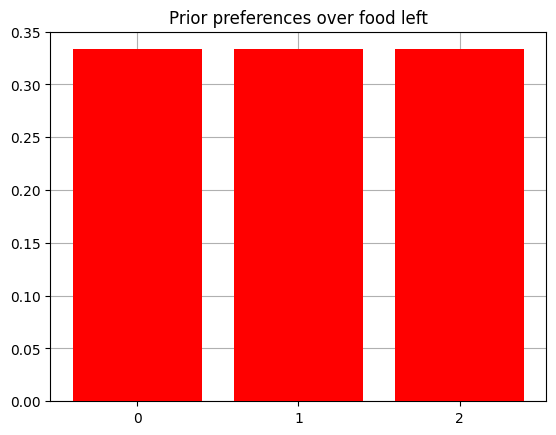

In [ ]:
utils.plot_beliefs(softmax(C3[0]), title = "Prior preferences over food left")


We set a new agent

In [ ]:
C3

array([array([5., 5., 5.]), array([ 0., 10., 20.])], dtype=object)

In [ ]:
# we set policy_len = 3 because in order to plan the agent need to look further than just 1 ts
my_agent3 = Agent(A=A2, B=B2, C=C3, B_factor_list=B2_factor_list, policy_len = 3, policies=None, action_selection="stochastic")

In [ ]:
my_agent3.policy_len


3

In [ ]:
my_agent3.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent3.E = my_agent3._construct_E_prior()

In [ ]:
my_agent3.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent3.policies)

8

**AIF loop**

We change the agent in the AIF loop.

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent3.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent3.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent3.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent3.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 2, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 3, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 4, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 5, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 6, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 7, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 8, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 9, Action taken: 1
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 2
Time step 2, Action taken: 0
Observation: [array([1]), array([1])]


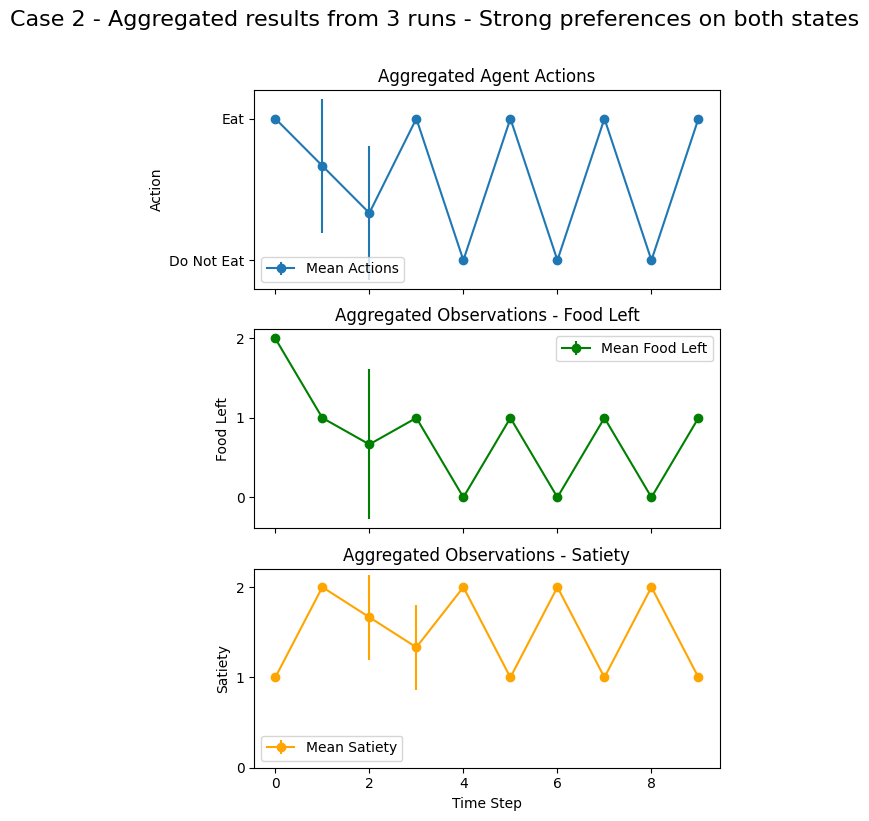

In [ ]:
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot the aggregated results
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs - Strong preferences on both states", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

By setting strong preferences on food left the agent keeps maintaining itself alive never getting to satiety = 0. (This is a bit trivial, not very useful as a proof of robustness)

### *2.4.3 Different environment*

In [ ]:
# change environment so that food and satiety levels change at different rates

In [ ]:
class room_Env2:
    def __init__(self):
        # Initial states
        self.state_food2 = 2  # food = 2 (full)
        self.state_satiety2 = 1  # satiety = 1 (half satisfied)

    def step(self, action):
        """
        Updates the environment state based on the agent's action and returns the observation.

        :param action: int, the action taken by the agent, 0 for 'do not eat', 1 for 'eat'
        :return: tuple, (observation_food, observation_satiety)
        """
        if action == 0:  # do not eat
            # increase food level if agent does not eat
            self.state_food2 = min(self.state_food2 + 1, 2)  # food level can grow up to 2
            self.state_satiety2 = max(self.state_satiety2 - 1, 0) # satiety decreases

        elif action == 1:  # eat
            if self.state_food2 > 0:  # can only eat if food is present
                # decrease food, increase satiety
                self.state_food2 -= 1
                self.state_satiety2 = min(self.state_satiety2 + 1, 2)
            elif self.state_food2==0:
                self.state_food2 = 0
                self.state_satiety2 = min(self.state_satiety2 - 1, 2)

        # mapping states to observations
        obs_food2 = self.state_food2  # directly use the state as observation
        obs_satiety2 = self.state_satiety2

        return [obs_food2, obs_satiety2]

    def reset(self):
        # reset the environment to the initial state
        self.state_food2 = 2  # Food full present
        self.state_satiety2 = 1  # Half satisfied

        return [self.state_food2, self.state_satiety2]

### *2.4.4 Different policy length*

In [ ]:
# cfr agent with different policy length (3/1) and check how many of the agents dies

Agent

In [ ]:
# we set policy_len = 1 so the agent does not actually plan
my_agent4 = Agent(A=A2, B=B2, C=C2, B_factor_list=B2_factor_list, policy_len = 1, policies=None, action_selection="stochastic")

In [ ]:
my_agent4.policy_len


1

In [ ]:
my_agent4.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent4.E = my_agent4._construct_E_prior()

In [ ]:
my_agent4.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent4.policies)

8

**AIF loop**

We can run the AIF loop several times to show results reliability

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent4.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent4.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent4.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent4.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 2, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 3, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 4, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 5, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 6, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 7, Action taken: 0
Observation: [array([2]), array([1])]

Run 1
Time step 8, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 9, Action taken: 1
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 2
Time step 2, Action taken: 0
Observation: [array([1]), array([1])]


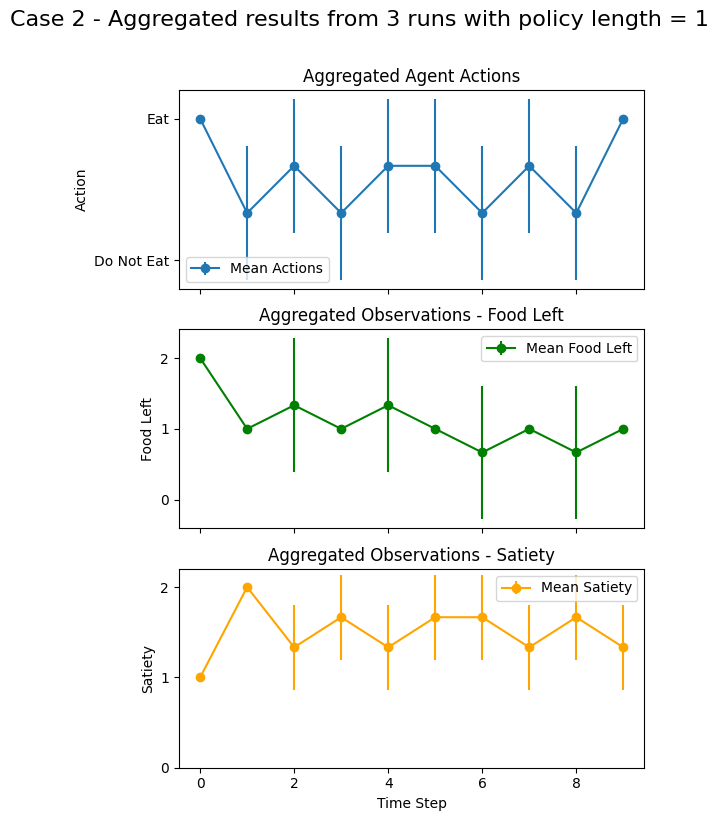

In [ ]:
#plot the aggregated results
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with policy length = 1", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

When the agent has a policy length = 1, i.e. does not plan, it keeps itself alive as well, but the food goes to 0 more often than when it plans 3 ts ahead.

In [ ]:
# we set policy_len = 1 so the agent does not actually plan
my_agent5 = Agent(A=A2, B=B2, C=C2, B_factor_list=B2_factor_list, policy_len = 2, policies=None, action_selection="stochastic")

In [ ]:
my_agent5.policy_len


2

In [ ]:
my_agent5.policies = restricted_policies

In [ ]:
# to adjust matrix size after having reduced policies

my_agent5.E = my_agent5._construct_E_prior()

In [ ]:
my_agent5.policies # we expect 8 policies 2^3

[array([[0, 0],
        [0, 0],
        [0, 0]]),
 array([[0, 0],
        [0, 0],
        [1, 1]]),
 array([[0, 0],
        [1, 1],
        [0, 0]]),
 array([[0, 0],
        [1, 1],
        [1, 1]]),
 array([[1, 1],
        [0, 0],
        [0, 0]]),
 array([[1, 1],
        [0, 0],
        [1, 1]]),
 array([[1, 1],
        [1, 1],
        [0, 0]]),
 array([[1, 1],
        [1, 1],
        [1, 1]])]

In [ ]:
len(my_agent5.policies)

8

**AIF loop**

We can run the AIF loop several times to show results reliability

In [ ]:
num_runs = 3

# length of active inference loop in time
T = 10

# initialize lists to store results
actions_list = []
observations_list = []

for run in range(num_runs):
    env = room_Env2()
    current_state = env.reset() # initialize or reset the env
    my_agent5.reset()

    actions = []
    observations = []
    satiety_zero_count = 0 # if satiety is 0 for more than 2 ts the agent dies

    for t in range(T):
        # get current observation from the environment
        if t == 0:
            observation = [np.array([current_state[0]]), np.array([current_state[1]])]
        else:
            obs = env.step(action)
            observation = [np.array([obs[0]]), np.array([obs[1]])]

        print(f"Observation: {observation}")
        print()

        # update the agent's belief about the current state based on the observation
        qs = my_agent5.infer_states(observation)  # Update state beliefs

        # infer policies based on the updated beliefs
        my_agent5.infer_policies()

        # sample the next action from the inferred policies
        action = my_agent5.sample_action()

        # handle action based on its type and structure
        if isinstance(action, np.ndarray) and action.size == 1:
            action = int(action.item())  # Convert single-item array to integer
        elif isinstance(action, np.ndarray) and action.ndim > 0:
            action = int(action[0])  # Select the first action if multiple are given
        else:
            print("Unexpected action format. Terminating loop.")
            break

          # Check for satiety level and update the count
        if observation[1] == 0:
            satiety_zero_count += 1
        else:
            satiety_zero_count = 0

          # Terminate loop if satiety = 0 for 1 time step
        if satiety_zero_count >= 1:
            print("AGENT DIES OF STARVATION.")
            print()
            break

        # store results for this timestep
        actions.append(action)
        observations.append(observation)


        # print results for this timestep
        print(f"Run {run + 1}")
        print(f"Time step {t}, Action taken: {action}")


    # Store results for this run
    actions_list.append(actions)
    observations_list.append(observations)

Observation: [array([2]), array([1])]

Run 1
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 1
Time step 1, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 2, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 3, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 4, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 5, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 6, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 7, Action taken: 1
Observation: [array([0]), array([2])]

Run 1
Time step 8, Action taken: 0
Observation: [array([1]), array([1])]

Run 1
Time step 9, Action taken: 1
Observation: [array([2]), array([1])]

Run 2
Time step 0, Action taken: 1
Observation: [array([1]), array([2])]

Run 2
Time step 1, Action taken: 0
Observation: [array([2]), array([1])]

Run 2
Time step 2, Action taken: 1
Observation: [array([1]), array([2])]


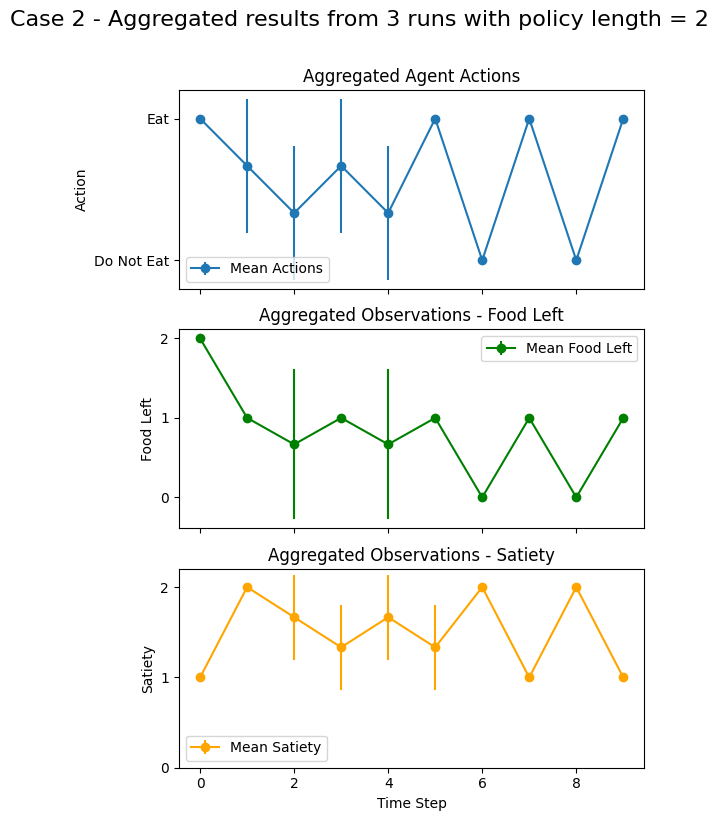

In [ ]:
#plot the aggregated results
# Number of runs
num_runs = len(observations_list)
T = len(observations_list[0])

# Initialize arrays to store aggregated data
actions_array = np.zeros((num_runs, T))
food_left_array = np.zeros((num_runs, T))
satiety_array = np.zeros((num_runs, T))

# Populate arrays with data from observations_list
for run in range(num_runs):
    actions_array[run, :] = actions_list[run]
    food_left_array[run, :] = [obs[0][0] for obs in observations_list[run]]
    satiety_array[run, :] = [obs[1][0] for obs in observations_list[run]]

# Calculate mean and standard deviation
mean_actions = np.mean(actions_array, axis=0)
std_actions = np.std(actions_array, axis=0)

mean_food_left = np.mean(food_left_array, axis=0)
std_food_left = np.std(food_left_array, axis=0)

mean_satiety = np.mean(satiety_array, axis=0)
std_satiety = np.std(satiety_array, axis=0)

# Plot
time_steps = range(T)

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Plotting aggregated actions
axs[0].errorbar(time_steps, mean_actions, yerr=std_actions, fmt='-o', label='Mean Actions')
axs[0].set_ylabel("Action")
axs[0].set_title("Aggregated Agent Actions")
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Do Not Eat", "Eat"])
axs[0].legend()

# Plotting aggregated observations - food left
axs[1].errorbar(time_steps, mean_food_left, yerr=std_food_left, fmt='-o', color='green', label='Mean Food Left')
axs[1].set_ylabel("Food Left")
axs[1].set_title("Aggregated Observations - Food Left")
axs[1].set_yticks([0, 1, 2])
axs[1].legend()

# Plotting aggregated observations - satiety
axs[2].errorbar(time_steps, mean_satiety, yerr=std_satiety, fmt='-o', color='orange', label='Mean Satiety')
axs[2].set_ylabel("Satiety")
axs[2].set_title("Aggregated Observations - Satiety")
axs[2].set_yticks([0, 1, 2])
axs[2].legend()

plt.xlabel("Time Step")
plt.tight_layout()

fig.suptitle("Case 2 - Aggregated results from 3 runs with policy length = 2", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)

plt.show()

Same results for policy length = 3.

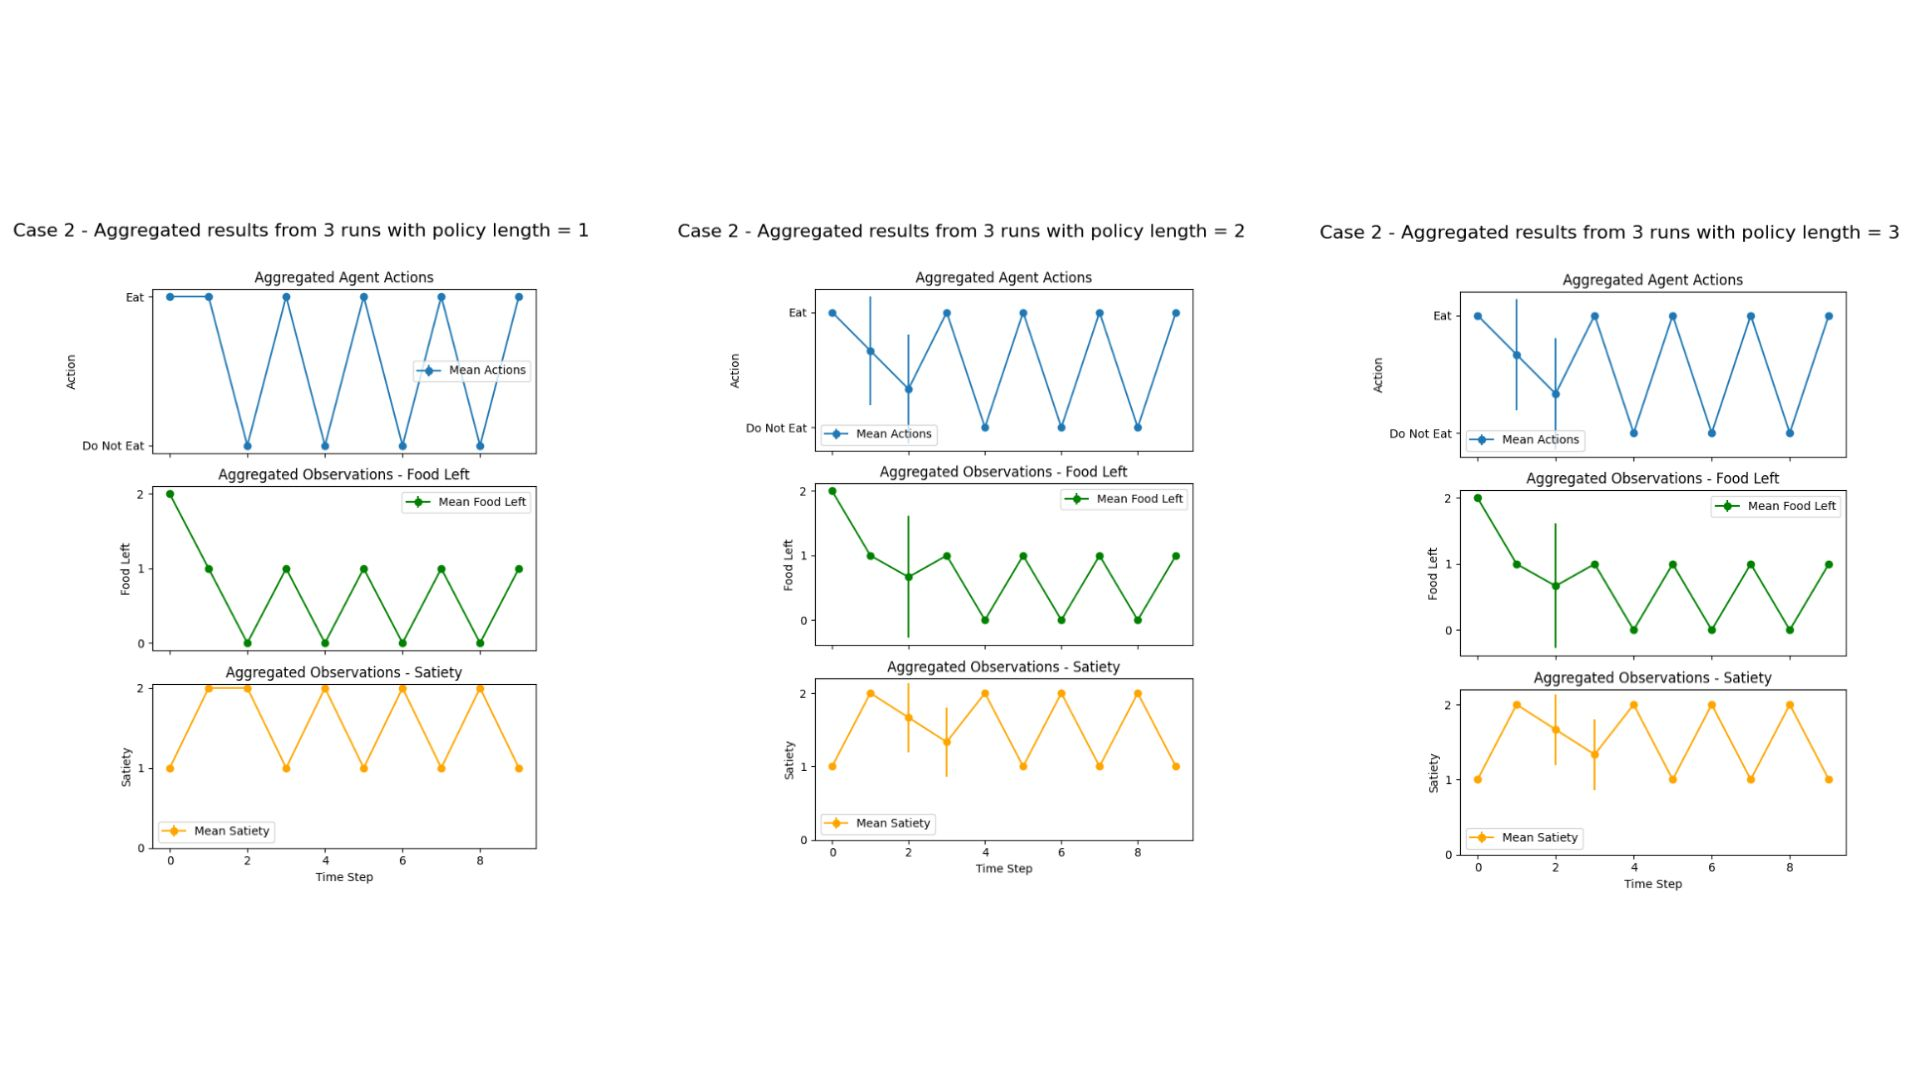